<a href="https://colab.research.google.com/github/zuhairnasir/Capstone_Project-code/blob/main/Gamuda_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

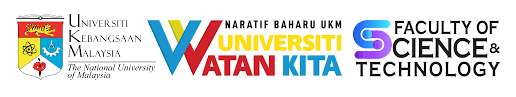
# **MACHINE LEARNING CLASSIFICATION OF EMPLOYABILITY OUTCOMES AMONG GAMUDA AI ACADEMY GRADUATES IN THE MALAYSIAN TECH SECTOR**
>
### **STQD6889 Capstone Project Semester 1 2025/2026**
>
*Muhammad Zuhair Afham Bin Mohd Nasir (P153944)*


In [1]:
print("📦 Installing required libraries...")
!pip install -q statsmodels

📦 Installing required libraries...


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
    )

In [3]:
# CONFIGURATION
# =============================================================================
DATA_PATH = '/content/drive/MyDrive/Gamuda_AI/data_gamuda.csv'
TARGET_COL = "employed_success(yes=1, no=0)"
REGION_COL = "cohort_region"
COHORT_COL = "cohort_number"
np.random.seed(42)


In [4]:
# STEP 1: DATA LOADING
# =============================================================================
print("\n" + "="*60)
print("📂 LOADING DATA")
print("="*60)

df = pd.read_csv(DATA_PATH).copy()



📂 LOADING DATA


In [5]:
# Normalize string columns (remove extra spaces, convert to lowercase)
str_cols = df.select_dtypes(include="object").columns
for c in str_cols:
    df[c] = df[c].astype(str).str.strip().str.lower()

# Ensure target is integer
df[TARGET_COL] = df[TARGET_COL].astype(int)

# Handle missing values
df["field_of_study"] = df["field_of_study"].replace("nan", np.nan).fillna("unknown")
df["employer_industry"] = df["employer_industry"].replace("nan", np.nan)

print(f"\n📊 Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"✓ Total Participants: {df.shape[0]}")
print(f"✓ Total Cohorts: {df[COHORT_COL].nunique()}")
print(f"✓ Regions: {', '.join(df[REGION_COL].unique())}")

print("\n📋 Column Names:")
print(df.columns.tolist())



📊 Dataset Shape: 239 rows × 14 columns
✓ Total Participants: 239
✓ Total Cohorts: 6
✓ Regions: kl, sabah

📋 Column Names:
['cohort_number', 'cohort_region', 'gender', 'age', 'education_level', 'field_of_study', 'group_income', 'location_home', 'attendance_pct', 'capstone_score', 'applications_sent', 'interview_attended', 'employed_success(yes=1, no=0)', 'employer_industry']


In [6]:
# STEP 2: DATA VALIDATION & QUALITY CHECK
# =============================================================================
print("\n" + "="*60)
print("✅ DATA VALIDATION & QUALITY CHECK")
print("="*60)

print("\n⚠️ Missing Values Check:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    print("\n💡 Note: Missing 'employer_industry' values are EXPECTED.")
    print("   This field only exists for employed graduates (employed_success = 1).")
    print(f"   Unemployed graduates: {(df[TARGET_COL] == 0).sum()}")
    print(f"   Missing employer_industry: {df['employer_industry'].isna().sum()}")

    unemployed_count = (df[TARGET_COL] == 0).sum()
    missing_industry = df['employer_industry'].isna().sum()

    if missing_industry == unemployed_count:
        print(f"   ✅ Confirmed: Missing values match unemployed count exactly!")
    elif missing_industry > unemployed_count:
        employed_missing = missing_industry - unemployed_count
        print(f"   ⚠️ Warning: {employed_missing} employed graduates also missing industry data")
else:
    print("No missing values detected!")




✅ DATA VALIDATION & QUALITY CHECK

⚠️ Missing Values Check:
employer_industry    64
dtype: int64

💡 Note: Missing 'employer_industry' values are EXPECTED.
   This field only exists for employed graduates (employed_success = 1).
   Unemployed graduates: 64
   Missing employer_industry: 64
   ✅ Confirmed: Missing values match unemployed count exactly!



🔍 Checking for Data Leakage (Employer Industry):
Industry Missing  False  True 
Employed                      
0                     0     64
1                   175      0

✅ Good: No unemployed graduates have industry data (no leakage)
✅ Perfect: All employed graduates have industry data

📊 Data Quality Summary:
   • Total rows: 239
   • Employed: 175 (73.2%)
   • Unemployed: 64 (26.8%)
   • Industry data available: 175
   • No duplicates found

📈 Value Range Validation:
   • Age range: 24 - 43 years
   • Attendance: 64.8% - 100.0%
   • Capstone score: 51 - 97
   • Applications sent: 2 - 18
   • Interviews attended: 0 - 5


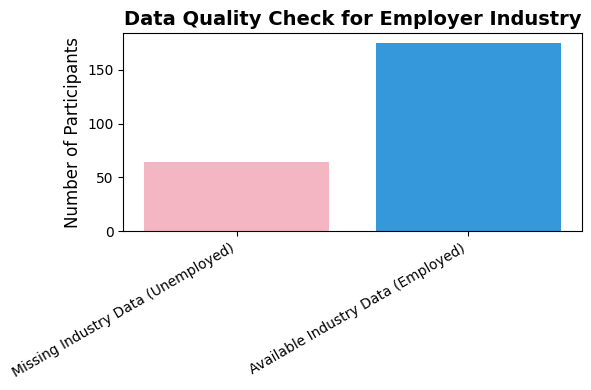

In [7]:
# Check for data leakage
print("\n🔍 Checking for Data Leakage (Employer Industry):")
leak_check = pd.crosstab(df[TARGET_COL], df['employer_industry'].isna(),
                         rownames=['Employed'], colnames=['Industry Missing'])
print(leak_check)

unemployed_with_industry = ((df[TARGET_COL] == 0) & (df['employer_industry'].notna())).sum()
employed_without_industry = ((df[TARGET_COL] == 1) & (df['employer_industry'].isna())).sum()

if unemployed_with_industry > 0:
    print(f"\n⚠️ WARNING: {unemployed_with_industry} unemployed graduates have industry data!")
else:
    print(f"\n✅ Good: No unemployed graduates have industry data (no leakage)")

if employed_without_industry > 0:
    print(f"⚠️ Note: {employed_without_industry} employed graduates missing industry data")
else:
    print(f"✅ Perfect: All employed graduates have industry data")

print(f"\n📊 Data Quality Summary:")
print(f"   • Total rows: {len(df)}")
print(f"   • Employed: {(df[TARGET_COL] == 1).sum()} ({(df[TARGET_COL] == 1).mean()*100:.1f}%)")
print(f"   • Unemployed: {(df[TARGET_COL] == 0).sum()} ({(df[TARGET_COL] == 0).mean()*100:.1f}%)")
print(f"   • Industry data available: {df['employer_industry'].notna().sum()}")
print(f"   • No duplicates found" if df.duplicated().sum() == 0 else f"   • ⚠️ {df.duplicated().sum()} duplicates found")

print(f"\n📈 Value Range Validation:")
print(f"   • Age range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"   • Attendance: {df['attendance_pct'].min()*100:.1f}% - {df['attendance_pct'].max()*100:.1f}%")
print(f"   • Capstone score: {df['capstone_score'].min():.0f} - {df['capstone_score'].max():.0f}")
print(f"   • Applications sent: {df['applications_sent'].min():.0f} - {df['applications_sent'].max():.0f}")
print(f"   • Interviews attended: {df['interview_attended'].min():.0f} - {df['interview_attended'].max():.0f}")


# Data Quality Visualization
categories = ['Missing Industry Data (Unemployed)', 'Available Industry Data (Employed)']
values = [(df[TARGET_COL] == 0).sum(), (df[TARGET_COL] == 1).sum()]

plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['#f4b6c2', '#3498db'])
plt.title('Data Quality Check for Employer Industry', fontsize=14, fontweight='bold')
plt.ylabel('Number of Participants', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



In [8]:
# STEP 3: DESCRIPTIVE STATISTICS
# =============================================================================
print("\n" + "="*60)
print("📈 DESCRIPTIVE STATISTICS")
print("="*60)

print(f"\n🎯 Overall Employment Rate: {df[TARGET_COL].mean():.2%}")
print(f"   ➤ Employed: {df[TARGET_COL].sum()} participants")
print(f"   ➤ Unemployed: {(~df[TARGET_COL].astype(bool)).sum()} participants")

print(f"\n📍 Regional Distribution:")
regional_counts = df[REGION_COL].value_counts()
for region, count in regional_counts.items():
    print(f"   ➤ {region.upper()}: {count} participants ({count/len(df)*100:.1f}%)")

print(f"\n💼 Employment Rate by Region:")
regional_emp = df.groupby(REGION_COL)[TARGET_COL].mean()
for region, rate in regional_emp.items():
    print(f"   ➤ {region.upper()}: {rate:.2%}")

print(f"\n💰 Employment Rate by Income Group:")
income_emp = df.groupby("group_income")[TARGET_COL].mean().sort_values(ascending=False)
for income, rate in income_emp.items():
    print(f"   ➤ {income.upper()}: {rate:.2%}")

print(f"\n👥 Gender Distribution:")
gender_counts = df["gender"].value_counts()
for gender, count in gender_counts.items():
    print(f"   ➤ {gender.capitalize()}: {count} participants ({count/len(df)*100:.1f}%)")

numeric_cols = ["age", "attendance_pct", "capstone_score", "applications_sent", "interview_attended"]
print(f"\n📊 Numeric Variables Summary:")
print(df[numeric_cols].describe().round(2).to_string())



📈 DESCRIPTIVE STATISTICS

🎯 Overall Employment Rate: 73.22%
   ➤ Employed: 175 participants
   ➤ Unemployed: 64 participants

📍 Regional Distribution:
   ➤ KL: 159 participants (66.5%)
   ➤ SABAH: 80 participants (33.5%)

💼 Employment Rate by Region:
   ➤ KL: 74.21%
   ➤ SABAH: 71.25%

💰 Employment Rate by Income Group:
   ➤ T20: 80.56%
   ➤ M40: 79.41%
   ➤ B40: 68.15%

👥 Gender Distribution:
   ➤ Female: 121 participants (50.6%)
   ➤ Male: 118 participants (49.4%)

📊 Numeric Variables Summary:
          age  attendance_pct  capstone_score  applications_sent  interview_attended
count  239.00          239.00          239.00             239.00              239.00
mean    30.64            0.86           74.12               9.90                2.01
std      4.99            0.08            8.32               3.24                1.04
min     24.00            0.65           51.00               2.00                0.00
25%     27.00            0.81           69.00               8.00         


🔍 EXPLORATORY DATA ANALYSIS

📊 Generating Figure 1: Employment Rate by Region...


/tmp/ipython-input-2078279158.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=REGION_COL, y=TARGET_COL, palette="viridis", ax=ax)


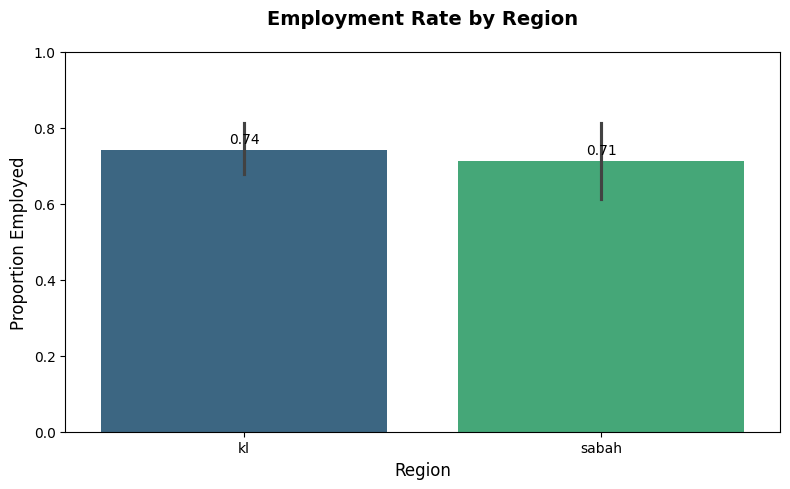

In [9]:
# STEP 4: EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print("\n" + "="*60)
print("🔍 EXPLORATORY DATA ANALYSIS")
print("="*60)

df["attendance_pct_100"] = df["attendance_pct"] * 100

# Figure 1: Employment Rate by Region
print("\n📊 Generating Figure 1: Employment Rate by Region...")
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df, x=REGION_COL, y=TARGET_COL, palette="viridis", ax=ax)
ax.set_title("Employment Rate by Region", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Proportion Employed", fontsize=12)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylim(0, 1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()

📊 Generating Figure 2: Employment Rate by Income Group...


/tmp/ipython-input-987074170.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="group_income", y=TARGET_COL, order=order_income, palette="coolwarm", ax=ax)


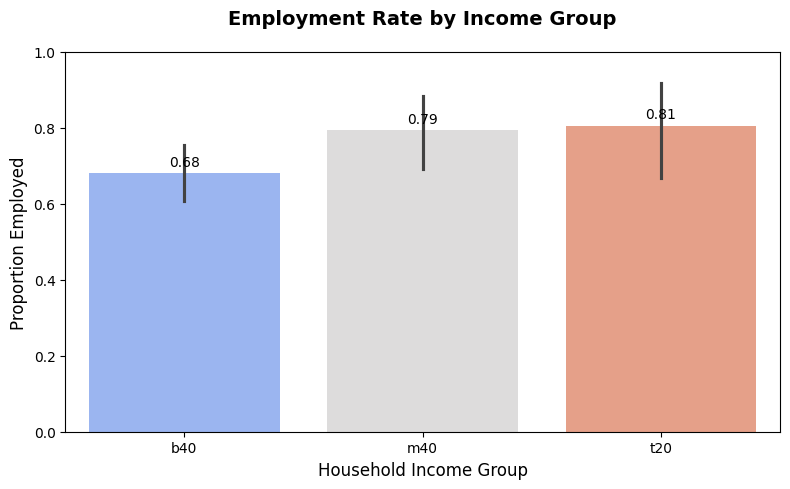

In [10]:
# Figure 2: Employment Rate by Income Group
print("📊 Generating Figure 2: Employment Rate by Income Group...")
fig, ax = plt.subplots(figsize=(8, 5))
order_income = ["b40", "m40", "t20"]
sns.barplot(data=df, x="group_income", y=TARGET_COL, order=order_income, palette="coolwarm", ax=ax)
ax.set_title("Employment Rate by Income Group", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Proportion Employed", fontsize=12)
ax.set_xlabel("Household Income Group", fontsize=12)
ax.set_ylim(0, 1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()


📊 Generating Figure 3: Attendance Distribution by Region...


/tmp/ipython-input-1309616752.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=REGION_COL, y="attendance_pct_100", palette="Set2", ax=ax)


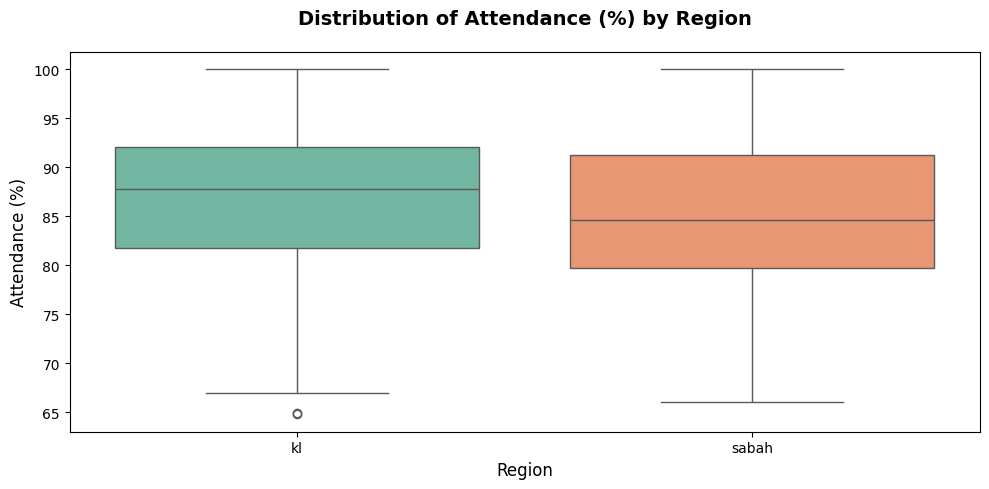

In [11]:
# Figure 3: Attendance Distribution by Region
print("📊 Generating Figure 3: Attendance Distribution by Region...")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x=REGION_COL, y="attendance_pct_100", palette="Set2", ax=ax)
ax.set_title("Distribution of Attendance (%) by Region", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Attendance (%)", fontsize=12)
plt.tight_layout()
plt.show()


📊 Generating Figure 4: Capstone Score Distribution by Region...


/tmp/ipython-input-2040114649.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=REGION_COL, y="capstone_score", palette="Set3", ax=ax)


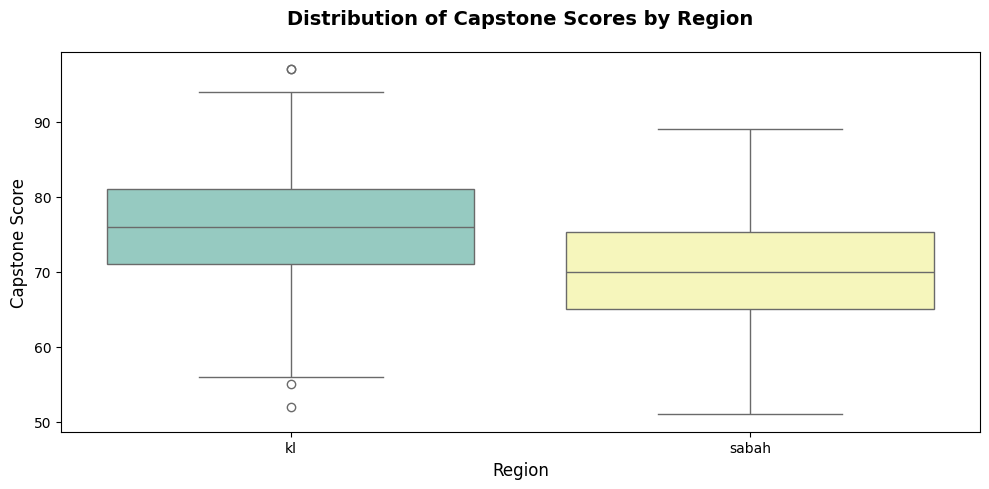

In [12]:
# Figure 4: Capstone Score Distribution by Region
print("📊 Generating Figure 4: Capstone Score Distribution by Region...")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df, x=REGION_COL, y="capstone_score", palette="Set3", ax=ax)
ax.set_title("Distribution of Capstone Scores by Region", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Region", fontsize=12)
ax.set_ylabel("Capstone Score", fontsize=12)
plt.tight_layout()
plt.show()


📊 Generating Figure 5: Correlation Heatmap...


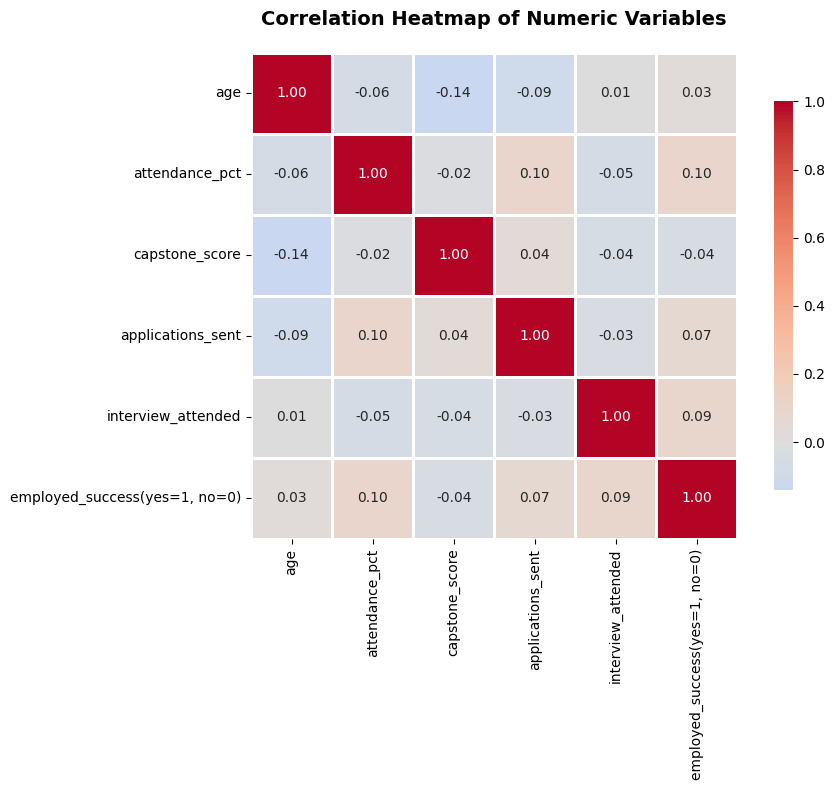


🔗 Key Correlations with Employment:
   ➤ attendance_pct: 0.103
   ➤ interview_attended: 0.089
   ➤ applications_sent: 0.068
   ➤ age: 0.028
   ➤ capstone_score: -0.043


In [13]:
# Figure 5: Correlation Heatmap
print("📊 Generating Figure 5: Correlation Heatmap...")
corr_cols = ["age", "attendance_pct", "capstone_score", "applications_sent",
             "interview_attended", TARGET_COL]
fig, ax = plt.subplots(figsize=(10, 8))
corr = df[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Correlation Heatmap of Numeric Variables", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print correlation insights
print("\n🔗 Key Correlations with Employment:")
emp_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
for var, corr_val in emp_corr.items():
    print(f"   ➤ {var}: {corr_val:.3f}")



📊 Generating Figure 6: Employment Rate by Field of Study...


/tmp/ipython-input-741554935.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=employment_rate_by_field.index, y=employment_rate_by_field.values, palette='pastel')


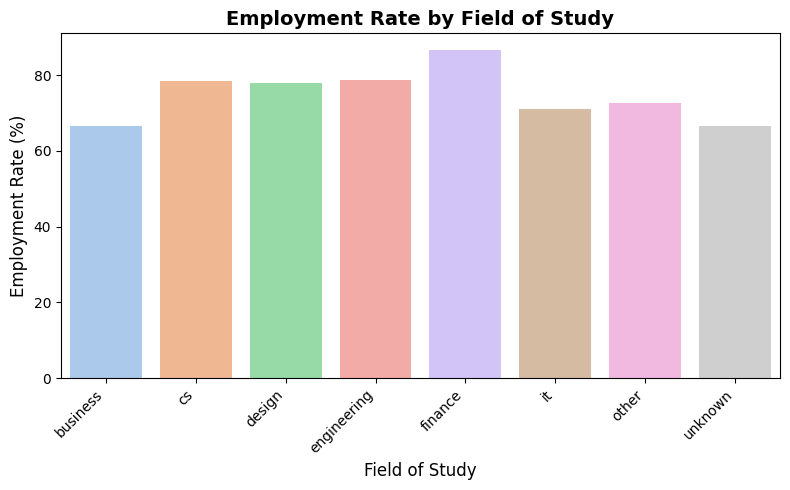

In [14]:
# Figure 6: Employment Rate by Field of Study
print("📊 Generating Figure 6: Employment Rate by Field of Study...")
employment_rate_by_field = df.groupby('field_of_study')[TARGET_COL].mean() * 100
plt.figure(figsize=(8, 5))
sns.barplot(x=employment_rate_by_field.index, y=employment_rate_by_field.values, palette='pastel')
plt.title('Employment Rate by Field of Study', fontsize=14, fontweight='bold')
plt.ylabel('Employment Rate (%)', fontsize=12)
plt.xlabel('Field of Study', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



📊 Generating Figure 7: Employment Rate by Cohort...


/tmp/ipython-input-3497469474.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=COHORT_COL, y=TARGET_COL, order=cohort_order, palette="mako", ax=ax)


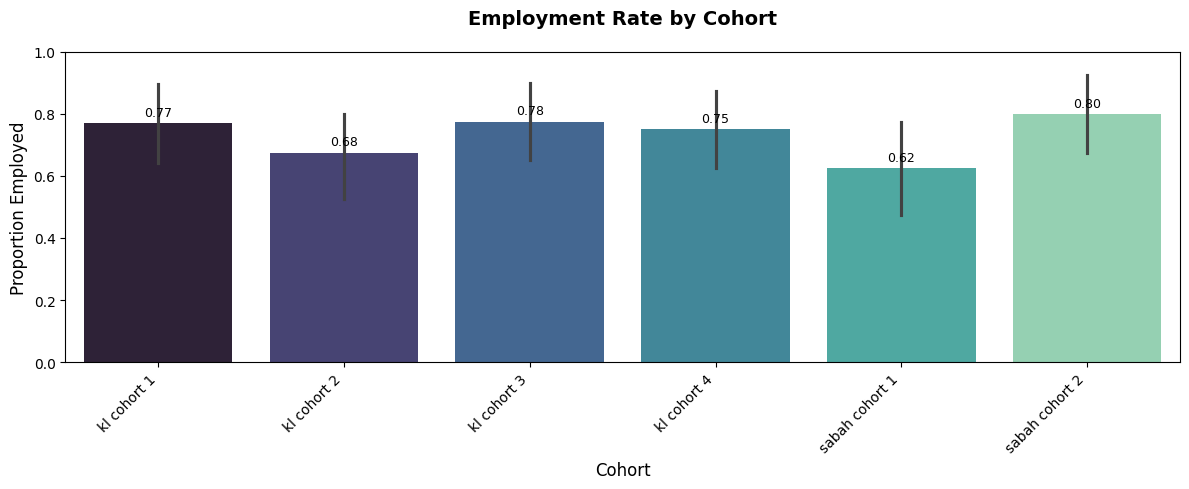

In [15]:
# Figure 7: Employment by Cohort
print("\n📊 Generating Figure 7: Employment Rate by Cohort...")
fig, ax = plt.subplots(figsize=(12, 5))
cohort_order = sorted(df[COHORT_COL].unique())
cohort_stats = df.groupby(COHORT_COL)[TARGET_COL].agg(['mean', 'count'])
sns.barplot(data=df, x=COHORT_COL, y=TARGET_COL, order=cohort_order, palette="mako", ax=ax)
ax.set_title("Employment Rate by Cohort", fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel("Proportion Employed", fontsize=12)
ax.set_xlabel("Cohort", fontsize=12)
ax.set_ylim(0, 1)
plt.xticks(rotation=45, ha='right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=9, padding=3)
plt.tight_layout()
plt.show()



📊 Generating Figure 8: Gender Distribution...


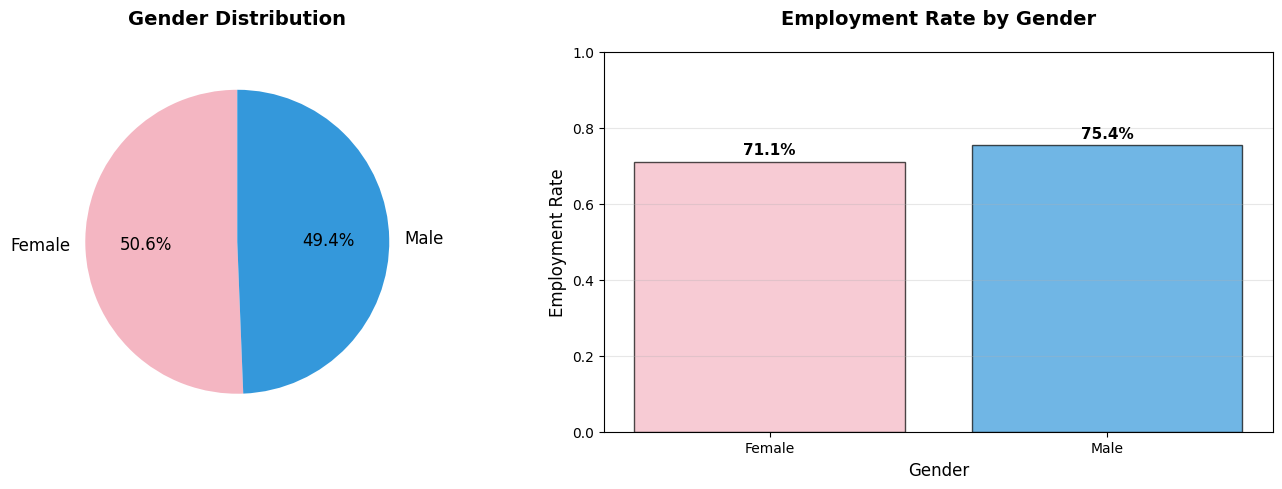

In [16]:
# Figure 8: Gender Distribution
print("\n📊 Generating Figure 8: Gender Distribution...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

gender_counts = df['gender'].value_counts()
colors_gender = ['#f4b6c2', '#3498db']
ax1.pie(gender_counts.values, labels=[g.capitalize() for g in gender_counts.index],
        autopct='%1.1f%%', startangle=90, colors=colors_gender, textprops={'fontsize': 12})
ax1.set_title("Gender Distribution", fontsize=14, fontweight='bold', pad=20)

gender_emp = df.groupby('gender')[TARGET_COL].mean()
ax2.bar(range(len(gender_emp)), gender_emp.values, color=colors_gender, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(gender_emp)))
ax2.set_xticklabels([g.capitalize() for g in gender_emp.index])
ax2.set_ylabel('Employment Rate', fontsize=12)
ax2.set_xlabel('Gender', fontsize=12)
ax2.set_title('Employment Rate by Gender', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylim(0, 1)
for i, v in enumerate(gender_emp.values):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=11, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



📊 Generating Figure 9: Age Distribution by Region...


/tmp/ipython-input-3450857869.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=REGION_COL, y='age', palette='Set2', ax=ax2)


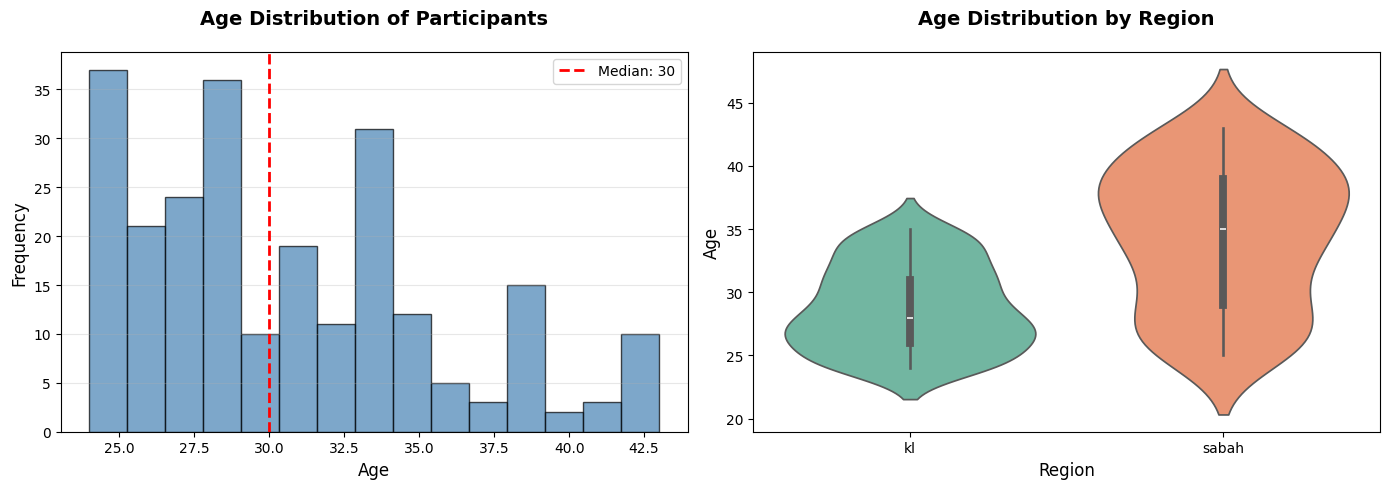

In [17]:
# Figure 9: Age Distribution by Region
print("\n📊 Generating Figure 9: Age Distribution by Region...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(df['age'], bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(df['age'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["age"].median():.0f}')
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Age Distribution of Participants', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

sns.violinplot(data=df, x=REGION_COL, y='age', palette='Set2', ax=ax2)
ax2.set_xlabel('Region', fontsize=12)
ax2.set_ylabel('Age', fontsize=12)
ax2.set_title('Age Distribution by Region', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()



📊 Generating Figure 10: Education Level Analysis...


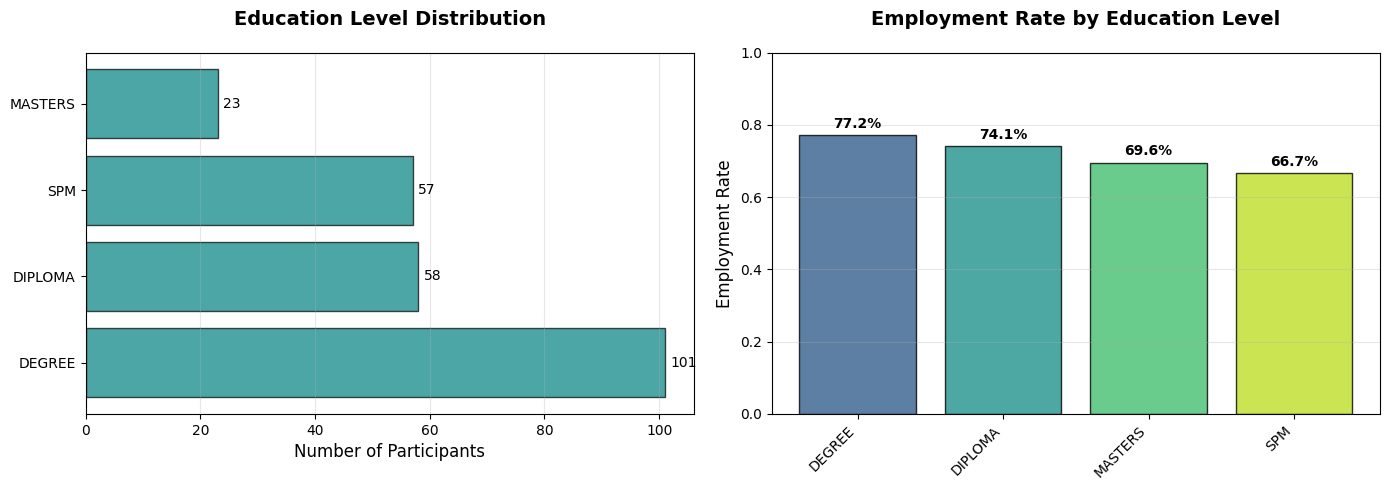

In [18]:
# Figure 10: Education Level Distribution and Employment
print("\n📊 Generating Figure 10: Education Level Analysis...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

edu_counts = df['education_level'].value_counts()
ax1.barh(range(len(edu_counts)), edu_counts.values, color='teal', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(edu_counts)))
ax1.set_yticklabels([e.upper() for e in edu_counts.index])
ax1.set_xlabel('Number of Participants', fontsize=12)
ax1.set_title('Education Level Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(edu_counts.values):
    ax1.text(v + 1, i, str(v), va='center', fontsize=10)

edu_emp = df.groupby('education_level')[TARGET_COL].mean().sort_values(ascending=False)
colors_edu = plt.cm.viridis(np.linspace(0.3, 0.9, len(edu_emp)))
ax2.bar(range(len(edu_emp)), edu_emp.values, color=colors_edu, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(edu_emp)))
ax2.set_xticklabels([e.upper() for e in edu_emp.index], rotation=45, ha='right')
ax2.set_ylabel('Employment Rate', fontsize=12)
ax2.set_title('Employment Rate by Education Level', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylim(0, 1)
for i, v in enumerate(edu_emp.values):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=10, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



📊 Generating Figure 10: Education Level Analysis...


/tmp/ipython-input-3067770351.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  edu_emp = df.groupby('education_level')[TARGET_COL].mean().reindex(edu_order)


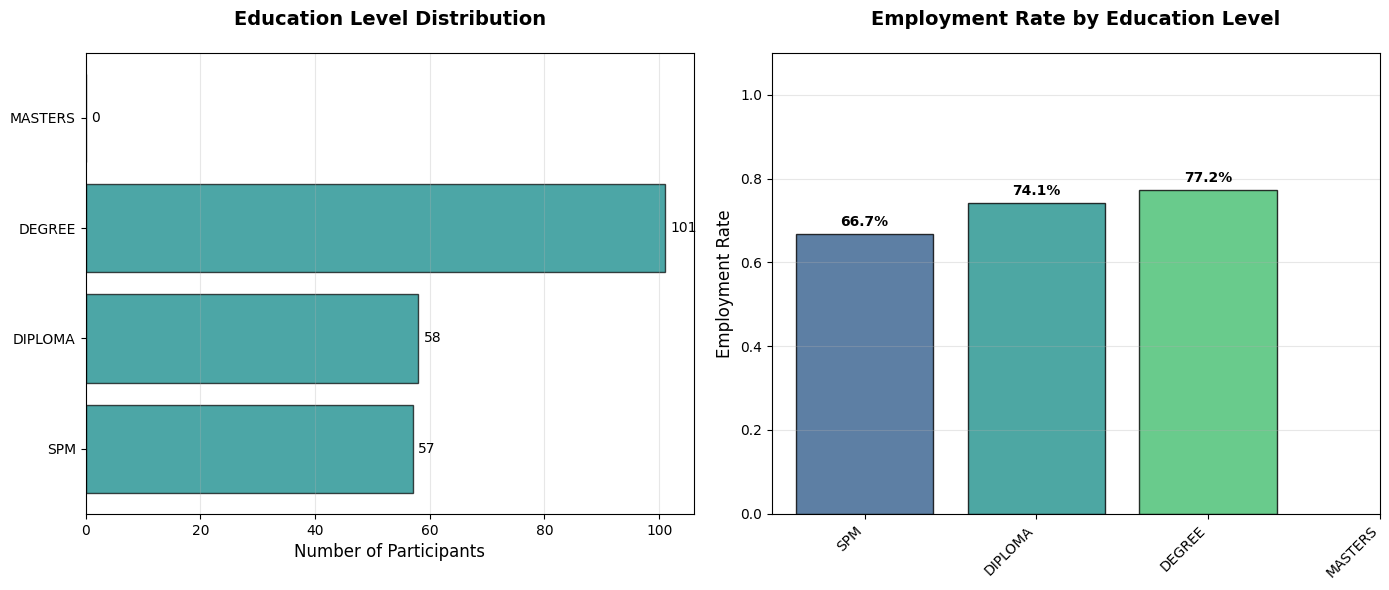

In [33]:
# 1. Define the desired order
edu_order = ['spm', 'diploma', 'degree', 'masters']

# 2. Convert to categorical type with ordering
df['education_level'] = pd.Categorical(df['education_level'], categories=edu_order, ordered=True)

# Figure 10: Education Level Distribution and Employment
print("\n📊 Generating Figure 10: Education Level Analysis...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: Distribution (Using the categorical order) ---
# We use sort_index() to ensure it follows SPM -> Master
edu_counts = df['education_level'].value_counts().sort_index()

ax1.barh(range(len(edu_counts)), edu_counts.values, color='teal', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(edu_counts)))
ax1.set_yticklabels([e.upper() for e in edu_counts.index])
ax1.set_xlabel('Number of Participants', fontsize=12)
ax1.set_title('Education Level Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)

for i, v in enumerate(edu_counts.values):
    ax1.text(v + 1, i, str(v), va='center', fontsize=10)

# --- Subplot 2: Employment Rate (Following the same order) ---
edu_emp = df.groupby('education_level')[TARGET_COL].mean().reindex(edu_order)

colors_edu = plt.cm.viridis(np.linspace(0.3, 0.9, len(edu_emp)))
ax2.bar(range(len(edu_emp)), edu_emp.values, color=colors_edu, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(edu_emp)))
ax2.set_xticklabels([e.upper() for e in edu_emp.index], rotation=45, ha='right')
ax2.set_ylabel('Employment Rate', fontsize=12)
ax2.set_title('Employment Rate by Education Level', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylim(0, 1.1) # Increased slightly to fit labels

for i, v in enumerate(edu_emp.values):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=10, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


📊 Generating Figure 11: Field of Study Analysis...


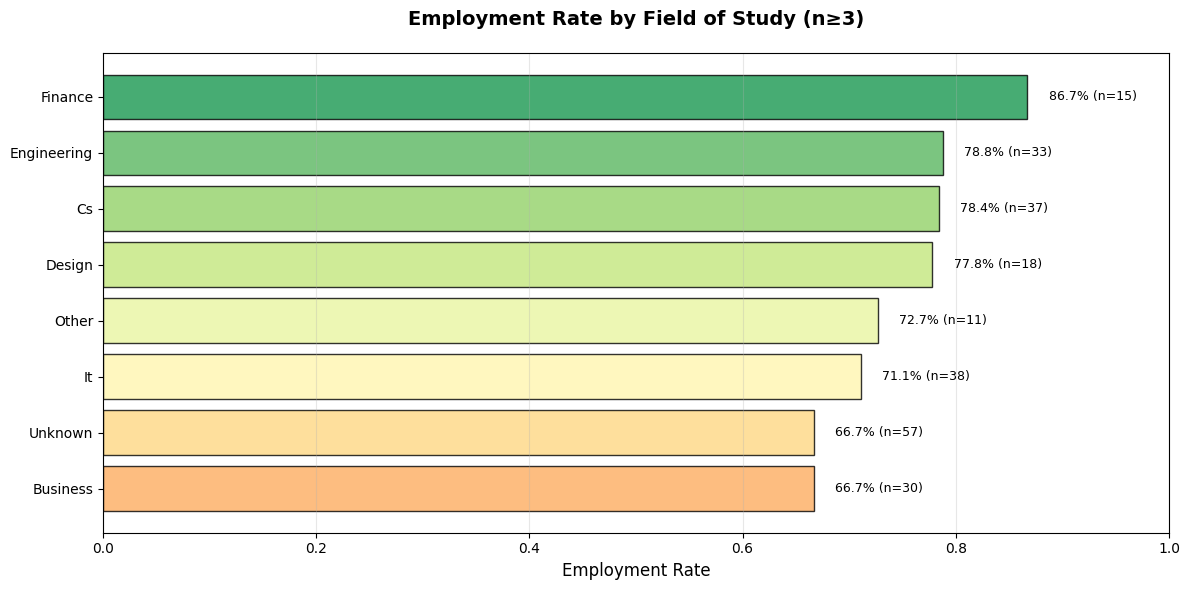

In [19]:
# Figure 11: Field of Study Distribution and Employment
print("\n📊 Generating Figure 11: Field of Study Analysis...")
fig, ax = plt.subplots(figsize=(12, 6))

field_emp = df.groupby('field_of_study').agg({
    TARGET_COL: ['mean', 'count']
}).round(3)
field_emp.columns = ['employment_rate', 'count']
field_emp = field_emp[field_emp['count'] >= 3]
field_emp = field_emp.sort_values('employment_rate', ascending=True)

colors_field = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(field_emp)))
bars = ax.barh(range(len(field_emp)), field_emp['employment_rate'].values,
               color=colors_field, alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(field_emp)))
ax.set_yticklabels([f.title() for f in field_emp.index])
ax.set_xlabel('Employment Rate', fontsize=12)
ax.set_title('Employment Rate by Field of Study (n≥3)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1)
ax.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(field_emp.iterrows()):
    ax.text(row['employment_rate'] + 0.02, i,
            f"{row['employment_rate']:.1%} (n={int(row['count'])})",
            va='center', fontsize=9)

plt.tight_layout()
plt.show()



📊 Generating Figure 11: Field of Study Analysis...


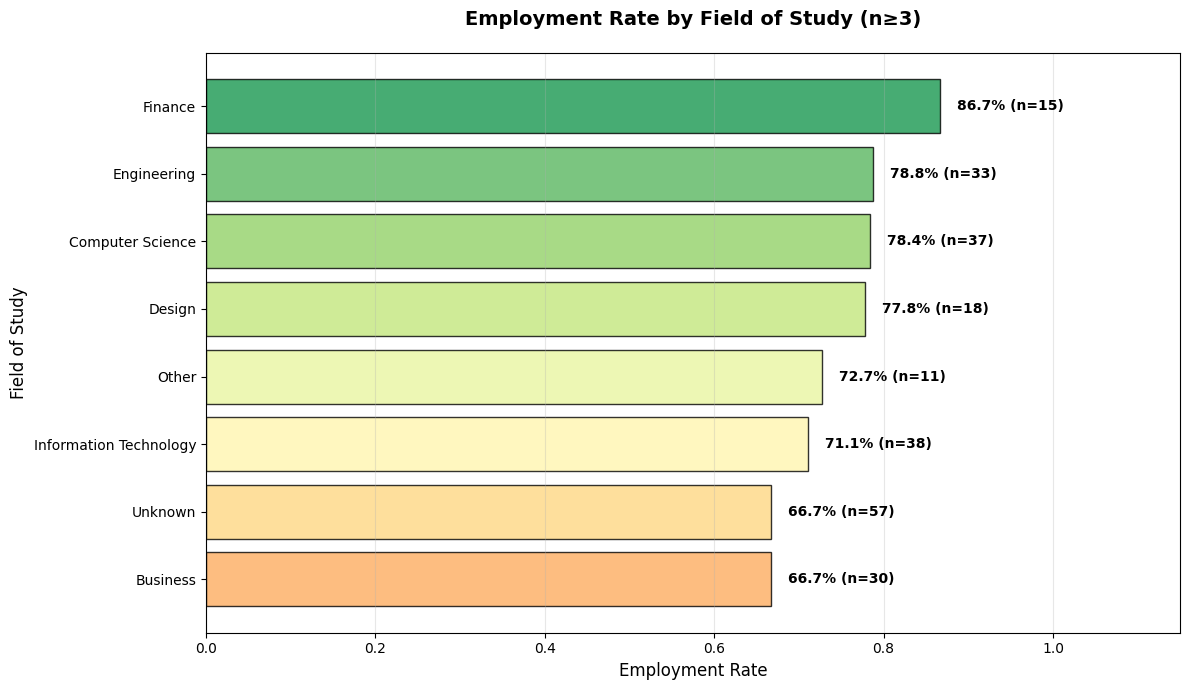

In [40]:
# Figure 11: Field of Study Distribution and Employment
print("\n📊 Generating Figure 11: Field of Study Analysis...")
fig, ax = plt.subplots(figsize=(12, 7))

# 1. Clean and Prepare the data
# Standardize strings to lowercase first to ensure matching works
df['field_of_study'] = df['field_of_study'].str.lower().str.strip()

# 2. Map abbreviations to full names
field_mapping = {
    'cs': 'Computer Science',
    'it': 'Information Technology'
}
df['field_of_study_display'] = df['field_of_study'].replace(field_mapping)

# 3. Aggregate data
field_emp = df.groupby('field_of_study_display').agg({
    TARGET_COL: ['mean', 'count']
}).round(3)
field_emp.columns = ['employment_rate', 'count']

# Filter for significance and sort
field_emp = field_emp[field_emp['count'] >= 3]
field_emp = field_emp.sort_values('employment_rate', ascending=True)

# 4. Plotting
colors_field = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(field_emp)))
bars = ax.barh(range(len(field_emp)), field_emp['employment_rate'].values,
               color=colors_field, alpha=0.8, edgecolor='black')

# Labels and Titles
ax.set_yticks(range(len(field_emp)))
# Ensure labels are Title Cased (except for IT which should be all caps)
labels = [l if l == 'Information Technology' else l.title() for l in field_emp.index]
ax.set_yticklabels(labels)

ax.set_xlabel('Employment Rate', fontsize=12)
ax.set_ylabel('Field of Study', fontsize=12) # Added Y-axis label
ax.set_title('Employment Rate by Field of Study (n≥3)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 1.15) # Extended limit to fit text labels
ax.grid(axis='x', alpha=0.3)

# Add data labels
for i, (idx, row) in enumerate(field_emp.iterrows()):
    ax.text(row['employment_rate'] + 0.02, i,
            f"{row['employment_rate']:.1%} (n={int(row['count'])})",
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


📊 Generating Figure 12: Job Search Behavior...


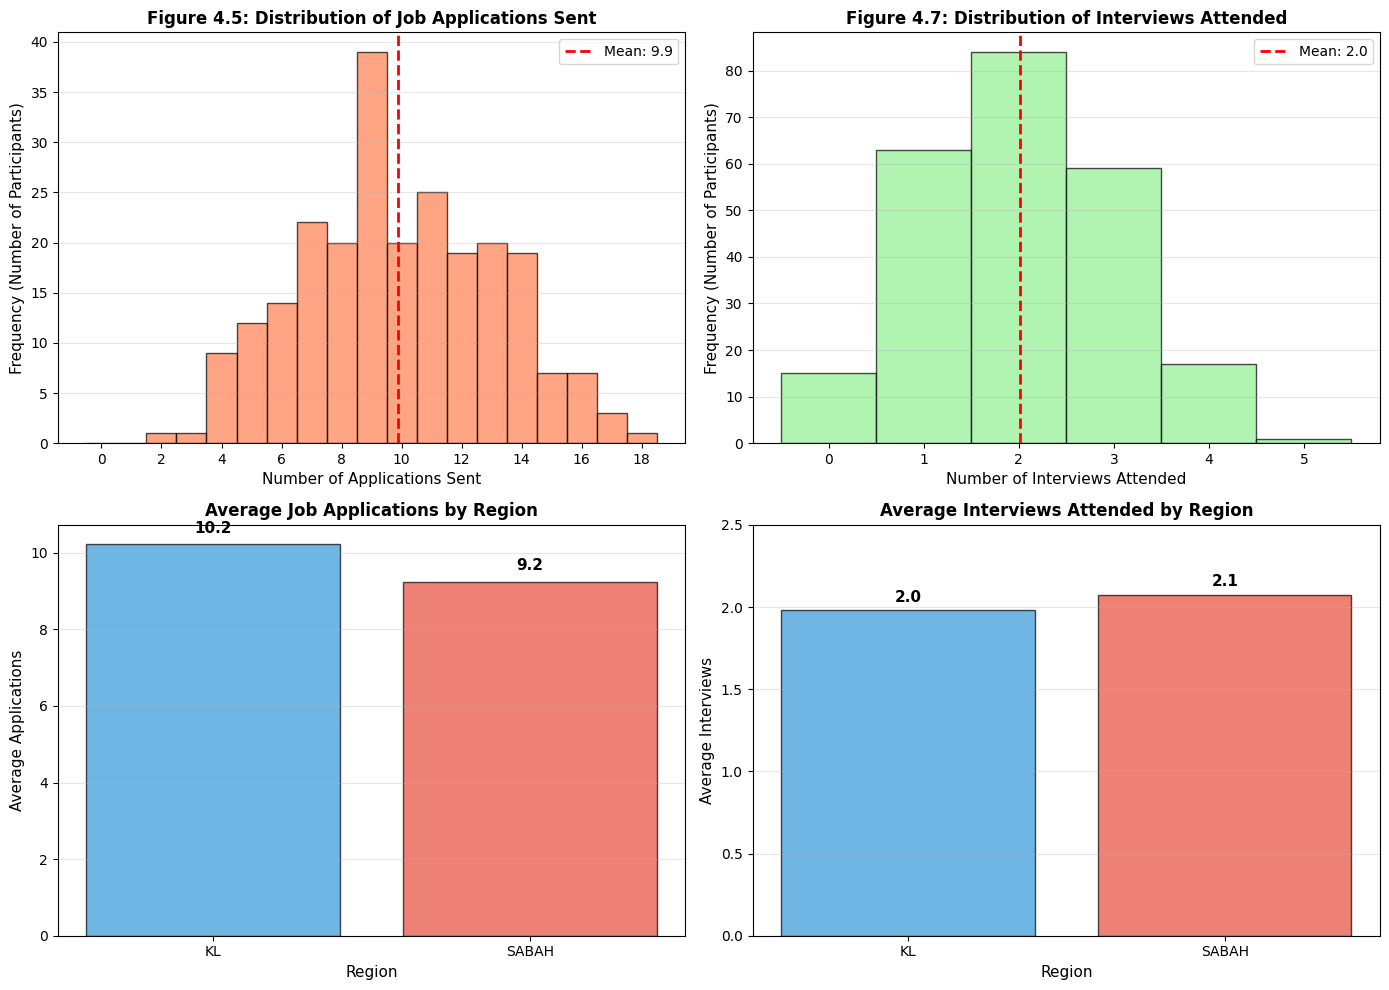

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Figure 12: Job Search Behavior Analysis
print("\n📊 Generating Figure 12: Job Search Behavior...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# --- ax1: Distribution of Job Applications Sent ---
max_apps = int(df['applications_sent'].max())
bins1 = np.arange(0, max_apps + 2) - 0.5
ax1.hist(df['applications_sent'], bins=bins1, color='coral', edgecolor='black', alpha=0.7)
ax1.axvline(df['applications_sent'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["applications_sent"].mean():.1f}')
ax1.set_xlabel('Number of Applications Sent', fontsize=11)
ax1.set_ylabel('Frequency (Number of Participants)', fontsize=11)
ax1.set_title('Figure 4.5: Distribution of Job Applications Sent', fontsize=12, fontweight='bold')
ax1.set_xticks(np.arange(0, max_apps + 1, 5 if max_apps > 20 else 2))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# --- ax2: Distribution of Interviews Attended ---
max_int = int(df['interview_attended'].max())
bins2 = np.arange(0, max_int + 2) - 0.5
ax2.hist(df['interview_attended'], bins=bins2, color='lightgreen', edgecolor='black', alpha=0.7)
ax2.axvline(df['interview_attended'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Mean: {df["interview_attended"].mean():.1f}')
ax2.set_xlabel('Number of Interviews Attended', fontsize=11)
ax2.set_ylabel('Frequency (Number of Participants)', fontsize=11)
ax2.set_title('Figure 4.7: Distribution of Interviews Attended', fontsize=12, fontweight='bold')
ax2.set_xticks(np.arange(0, max_int + 1, 1 if max_int < 10 else 2))
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# --- ax3: Average Job Applications by Region ---
region_apps = df.groupby(REGION_COL)['applications_sent'].mean()
ax3.bar(range(len(region_apps)), region_apps.values, color=['#3498db', '#e74c3c'],
        alpha=0.7, edgecolor='black')
ax3.set_xticks(range(len(region_apps)))
ax3.set_xticklabels([r.upper() for r in region_apps.index])
ax3.set_xlabel('Region', fontsize=11)
ax3.set_ylabel('Average Applications', fontsize=11)
ax3.set_title('Average Job Applications by Region', fontsize=12, fontweight='bold')
for i, v in enumerate(region_apps.values):
    ax3.text(i, v + 0.3, f'{v:.1f}', ha='center', fontsize=11, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# --- ax4: Average Interviews Attended by Region ---
region_interviews = df.groupby(REGION_COL)['interview_attended'].mean()
ax4.bar(range(len(region_interviews)), region_interviews.values,
        color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
ax4.set_xticks(range(len(region_interviews)))
ax4.set_xticklabels([r.upper() for r in region_interviews.index])
ax4.set_xlabel('Region', fontsize=11)
ax4.set_ylabel('Average Interviews', fontsize=11)
ax4.set_title('Average Interviews Attended by Region', fontsize=12, fontweight='bold')
# Setting the Y-axis limit to 2.5 as requested
ax4.set_ylim(0, 2.5)
for i, v in enumerate(region_interviews.values):
    ax4.text(i, v + 0.05, f'{v:.1f}', ha='center', fontsize=11, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


📊 Generating Figure 13: Performance Metrics Comparison (KL vs Sabah)...


/tmp/ipython-input-222189338.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['KL', 'Sabah'], patch_artist=True,
/tmp/ipython-input-222189338.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['KL', 'Sabah'], patch_artist=True,
/tmp/ipython-input-222189338.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['KL', 'Sabah'], patch_artist=True,
/tmp/ipython-input-222189338.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppo

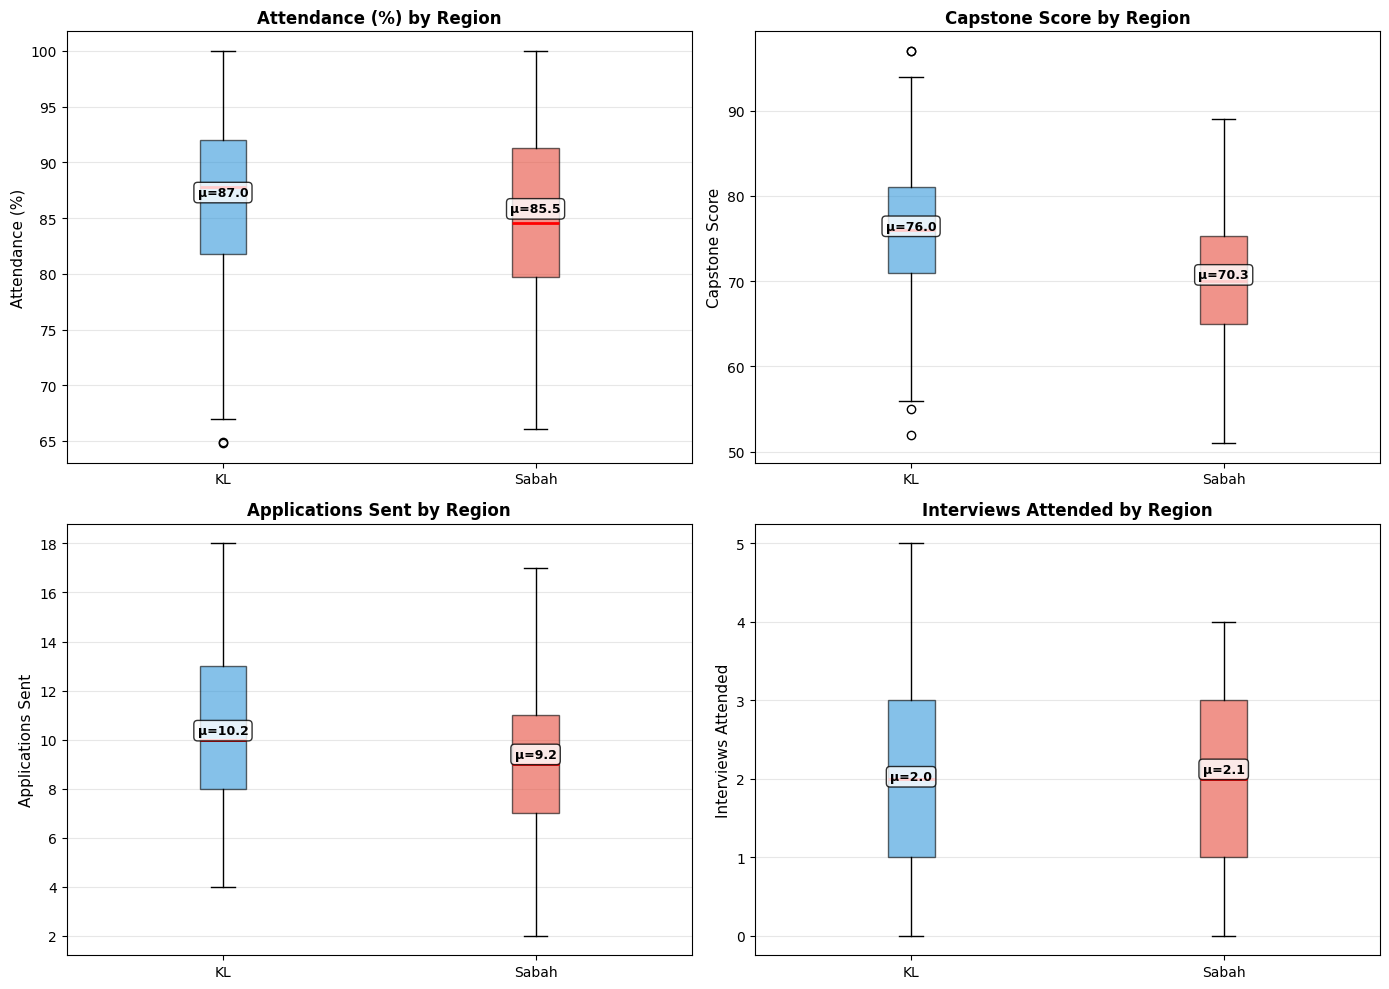

In [21]:
# Figure 13: Performance Metrics by Region Comparison
print("\n📊 Generating Figure 13: Performance Metrics Comparison (KL vs Sabah)...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['attendance_pct_100', 'capstone_score', 'applications_sent', 'interview_attended']
titles = ['Attendance (%)', 'Capstone Score', 'Applications Sent', 'Interviews Attended']
axes = [ax1, ax2, ax3, ax4]

for ax, metric, title in zip(axes, metrics, titles):
    data_to_plot = [df[df[REGION_COL] == 'kl'][metric].dropna(),
                    df[df[REGION_COL] == 'sabah'][metric].dropna()]

    bp = ax.boxplot(data_to_plot, labels=['KL', 'Sabah'], patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'))

    colors = ['#3498db', '#e74c3c']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_ylabel(title, fontsize=11)
    ax.set_title(f'{title} by Region', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    for i, region in enumerate(['kl', 'sabah']):
        mean_val = df[df[REGION_COL] == region][metric].mean()
        ax.text(i+1, mean_val, f'μ={mean_val:.1f}', ha='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()



In [22]:
# STEP 5: MACHINE LEARNING - PREPARATION
# =============================================================================
print("\n" + "="*60)
print("🤖 MACHINE LEARNING CLASSIFICATION")
print("="*60)

# Prepare features
numeric_features = ["age", "attendance_pct", "capstone_score", "applications_sent", "interview_attended"]
categorical_features = ["gender", "group_income", "location_home", REGION_COL, "education_level", "field_of_study"]

DROP_COLS = [TARGET_COL, "employer_industry"]
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

X = df[numeric_features + categorical_features]
y = df[TARGET_COL].astype(int)

print(f"\n📊 Feature Information:")
print(f"   ➤ Numeric features: {len(numeric_features)}")
print(f"   ➤ Categorical features: {len(categorical_features)}")
print(f"   ➤ Total features: {len(numeric_features) + len(categorical_features)}")

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Models
log_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=5000, solver="liblinear", random_state=42))
])

rf_clf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        class_weight="balanced_subsample",
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4
    ))
])



🤖 MACHINE LEARNING CLASSIFICATION

📊 Feature Information:
   ➤ Numeric features: 5
   ➤ Categorical features: 6
   ➤ Total features: 11


In [23]:
# STEP 6: UTILITY FUNCTIONS FOR REGIONAL ANALYSIS
# =============================================================================

def get_subset_by_region(df: pd.DataFrame, region_keyword: str) -> pd.DataFrame:
    """Get data subset for specific region"""
    region_keyword = region_keyword.lower()
    if REGION_COL in df.columns:
        return df[df[REGION_COL].astype(str).str.lower().str.contains(region_keyword, na=False)]
    elif "cohort_name" in df.columns:
        return df[df["cohort_name"].astype(str).str.lower().str.contains(region_keyword, na=False)]
    else:
        raise ValueError("No 'cohort_region' or 'cohort_name' column found.")

def _safe_stratify(y: pd.Series):
    """Return y for stratify only if valid"""
    if y.nunique() < 2:
        return None
    vc = y.value_counts()
    if (vc.min() < 2):
        return None
    return y

def _safe_n_splits(y: pd.Series, max_splits: int = 5) -> int:
    """Get safe number of splits for cross-validation"""
    if y.nunique() < 2:
        return 2
    min_class = int(y.value_counts().min())
    n_splits = min(max_splits, min_class)
    return max(2, n_splits)

def plot_confusion(ax, y_true, y_pred, title, cmap="Blues"):
    """Plot confusion matrix"""
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                                   display_labels=[0, 1])
    disp.plot(ax=ax, cmap=cmap, colorbar=False, values_format="d")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted", fontsize=10)
    ax.set_ylabel("Actual", fontsize=10)
    ax.grid(False)

def plot_roc(ax, y_true, y_prob, title, line_color="C0"):
    """Plot ROC curve"""
    if len(np.unique(y_true)) < 2:
        ax.text(0.5, 0.5, "ROC not available\n(only 1 class in test set)",
                ha="center", va="center", fontsize=10, fontweight="bold")
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
        ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        return

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, linewidth=2.5, color=line_color, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("False Positive Rate", fontsize=10)
    ax.set_ylabel("True Positive Rate", fontsize=10)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.legend(loc="lower right")
    ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)



📊 OVERALL MODEL EVALUATION (FULL DATASET)

📊 Data Split:
   ➤ Training set: 191 samples (79.9%)
   ➤ Testing set: 48 samples (20.1%)

📍 Baseline Accuracy (majority class): 72.92%

🎯 Logistic Regression
⏳ Training model...
✅ Training complete!

📊 Classification Report:
              precision    recall  f1-score   support

Not Employed      1.000     0.077     0.143        13
    Employed      0.745     1.000     0.854        35

    accuracy                          0.750        48
   macro avg      0.872     0.538     0.498        48
weighted avg      0.814     0.750     0.661        48

📊 Generating Confusion Matrix...


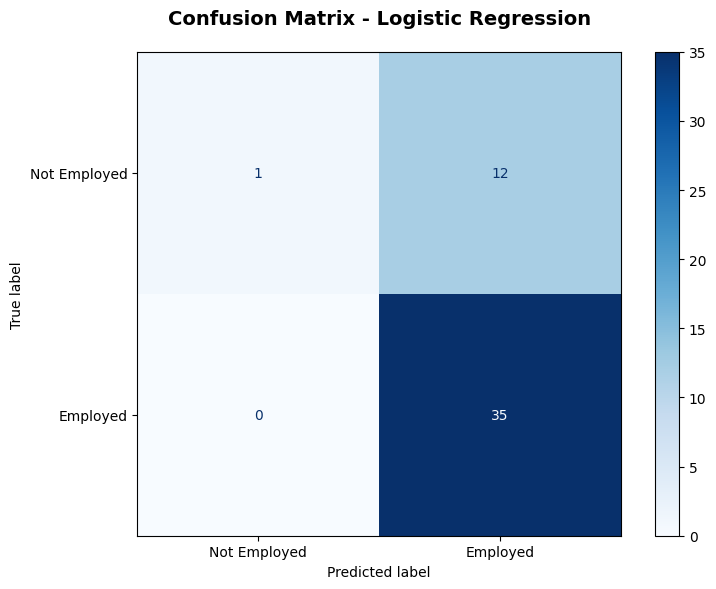


🎯 ROC-AUC Score: 0.541
📊 Generating ROC Curve...


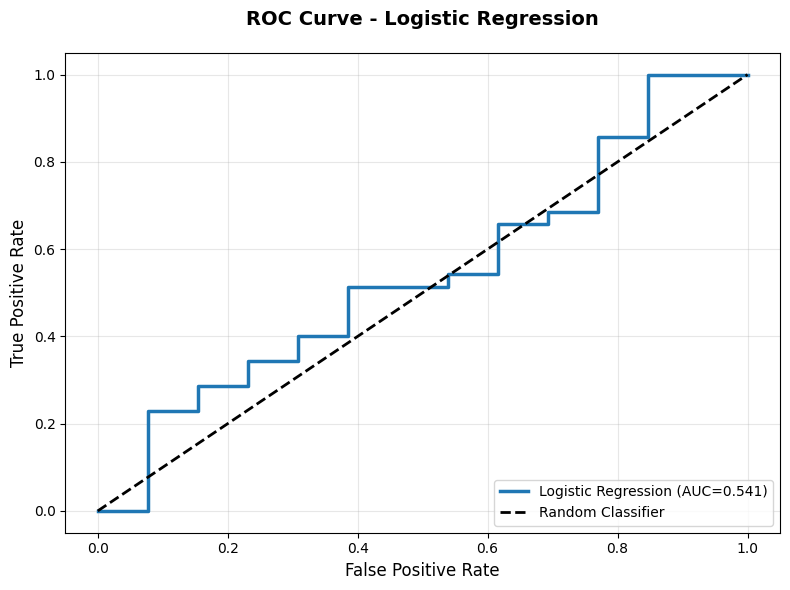


🎯 Random Forest
⏳ Training model...
✅ Training complete!

📊 Classification Report:
              precision    recall  f1-score   support

Not Employed      0.222     0.154     0.182        13
    Employed      0.718     0.800     0.757        35

    accuracy                          0.625        48
   macro avg      0.470     0.477     0.469        48
weighted avg      0.584     0.625     0.601        48

📊 Generating Confusion Matrix...


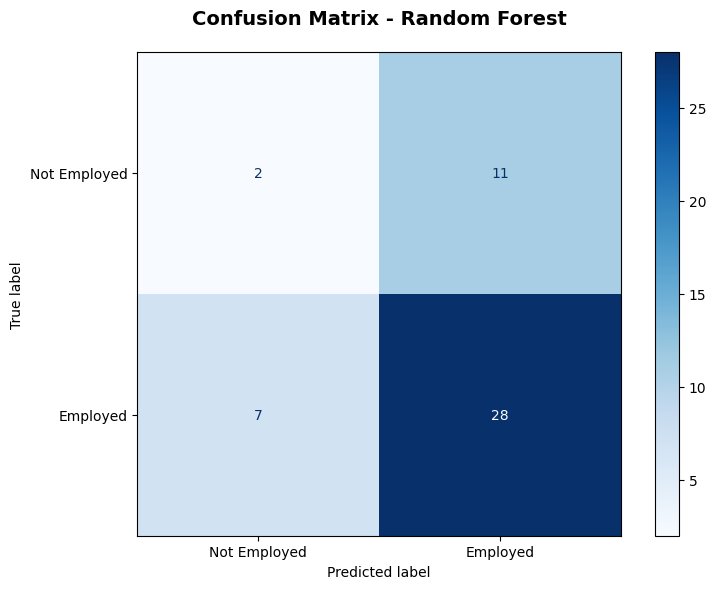


🎯 ROC-AUC Score: 0.424
📊 Generating ROC Curve...


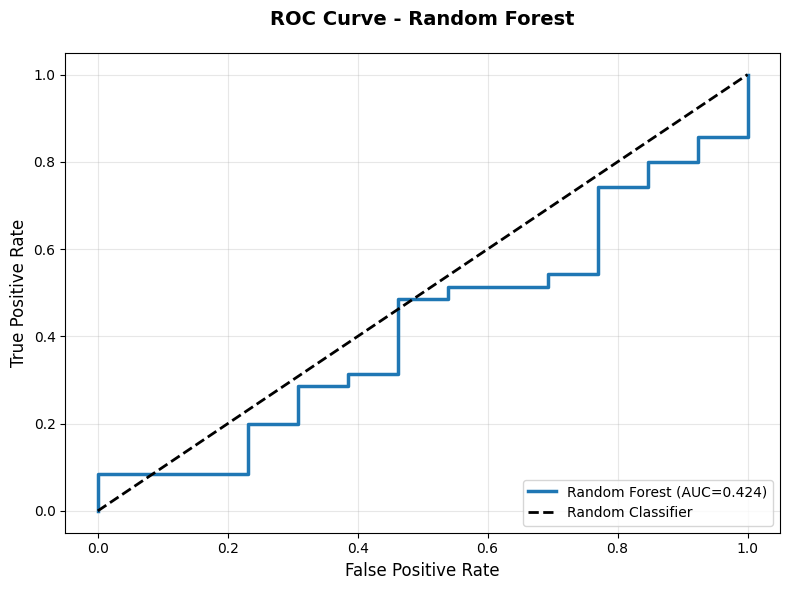

In [24]:
# STEP 7: OVERALL MODEL EVALUATION (FULL DATASET)
# =============================================================================
print("\n" + "="*60)
print("📊 OVERALL MODEL EVALUATION (FULL DATASET)")
print("="*60)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Data Split:")
print(f"   ➤ Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   ➤ Testing set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

baseline_acc = max(y_test.mean(), 1 - y_test.mean())
print(f"\n📍 Baseline Accuracy (majority class): {baseline_acc:.2%}")

def evaluate_model(model, X_train, X_test, y_train, y_test, title):
    """Train and evaluate a classification model"""
    print(f"\n{'='*60}")
    print(f"🎯 {title}")
    print(f"{'='*60}")

    print("⏳ Training model...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("✅ Training complete!")

    print("\n📊 Classification Report:")
    print(classification_report(y_test, pred, digits=3,
                                target_names=["Not Employed", "Employed"]))

    print("📊 Generating Confusion Matrix...")
    cm = confusion_matrix(y_test, pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Employed", "Employed"])
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    ax.set_title(f"Confusion Matrix - {title}", fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

    if len(np.unique(y_test)) == 2:
        proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, proba)
        print(f"\n🎯 ROC-AUC Score: {auc_score:.3f}")

        print("📊 Generating ROC Curve...")
        fig, ax = plt.subplots(figsize=(8, 6))
        fpr, tpr, _ = roc_curve(y_test, proba)
        ax.plot(fpr, tpr, linewidth=2.5, label=f'{title} (AUC={auc_score:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
        ax.set_title(f"ROC Curve - {title}", fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel("False Positive Rate", fontsize=12)
        ax.set_ylabel("True Positive Rate", fontsize=12)
        ax.legend(loc='lower right')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Evaluate Logistic Regression
evaluate_model(log_clf, X_train, X_test, y_train, y_test, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(rf_clf, X_train, X_test, y_train, y_test, "Random Forest")



In [25]:
# STEP 8: CROSS-VALIDATION (FULL DATASET)
# =============================================================================
print("\n" + "="*60)
print("🔄 CROSS-VALIDATION RESULTS (5-Fold Stratified)")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("⏳ Running 5-fold cross-validation for Random Forest...")

cv_scores = cross_validate(
    rf_clf, X, y, cv=cv,
    scoring=["accuracy", "roc_auc", "f1", "precision", "recall"],
    return_train_score=False,
    verbose=0
)

print("\n✅ Cross-validation complete!")
print(f"\n📊 Random Forest Cross-Validation Results:")
print(f"   ➤ Accuracy:  {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
print(f"   ➤ ROC-AUC:   {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
print(f"   ➤ F1-Score:  {cv_scores['test_f1'].mean():.3f} ± {cv_scores['test_f1'].std():.3f}")
print(f"   ➤ Precision: {cv_scores['test_precision'].mean():.3f} ± {cv_scores['test_precision'].std():.3f}")
print(f"   ➤ Recall:    {cv_scores['test_recall'].mean():.3f} ± {cv_scores['test_recall'].std():.3f}")

print("\n⏳ Running 5-fold cross-validation for Logistic Regression...")
cv_scores_lr = cross_validate(
    log_clf, X, y, cv=cv,
    scoring=["accuracy", "roc_auc", "f1", "precision", "recall"],
    return_train_score=False,
    verbose=0
)

print("\n✅ Cross-validation complete!")
print(f"\n📊 Logistic Regression Cross-Validation Results:")
print(f"   ➤ Accuracy:  {cv_scores_lr['test_accuracy'].mean():.3f} ± {cv_scores_lr['test_accuracy'].std():.3f}")
print(f"   ➤ ROC-AUC:   {cv_scores_lr['test_roc_auc'].mean():.3f} ± {cv_scores_lr['test_roc_auc'].std():.3f}")
print(f"   ➤ F1-Score:  {cv_scores_lr['test_f1'].mean():.3f} ± {cv_scores_lr['test_f1'].std():.3f}")
print(f"   ➤ Precision: {cv_scores_lr['test_precision'].mean():.3f} ± {cv_scores_lr['test_precision'].std():.3f}")
print(f"   ➤ Recall:    {cv_scores_lr['test_recall'].mean():.3f} ± {cv_scores_lr['test_recall'].std():.3f}")




🔄 CROSS-VALIDATION RESULTS (5-Fold Stratified)
⏳ Running 5-fold cross-validation for Random Forest...

✅ Cross-validation complete!

📊 Random Forest Cross-Validation Results:
   ➤ Accuracy:  0.641 ± 0.065
   ➤ ROC-AUC:   0.498 ± 0.097
   ➤ F1-Score:  0.769 ± 0.045
   ➤ Precision: 0.726 ± 0.039
   ➤ Recall:    0.817 ± 0.053

⏳ Running 5-fold cross-validation for Logistic Regression...

✅ Cross-validation complete!

📊 Logistic Regression Cross-Validation Results:
   ➤ Accuracy:  0.707 ± 0.040
   ➤ ROC-AUC:   0.493 ± 0.068
   ➤ F1-Score:  0.826 ± 0.025
   ➤ Precision: 0.731 ± 0.023
   ➤ Recall:    0.949 ± 0.028



🗺️ REGIONAL ANALYSIS: KL vs SABAH

Rows total: 239
Rows KL   : 159
Rows Sabah: 80

KL Cohorts (1–4) | HOLDOUT EVALUATION

--- Logistic Regression ---
Accuracy : 0.7188
Precision: 0.7419
Recall   : 0.9583
F1-score : 0.8364

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.74      0.96      0.84        24

    accuracy                           0.72        32
   macro avg       0.37      0.48      0.42        32
weighted avg       0.56      0.72      0.63        32


--- Random Forest ---
Accuracy : 0.5938
Precision: 0.7037
Recall   : 0.7917
F1-score : 0.7451

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.70      0.79      0.75        24

    accuracy                           0.59        32
   macro avg       0.35      0.40      0.37        32
weighted avg       0.53      0.59  

/tmp/ipython-input-1940193194.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


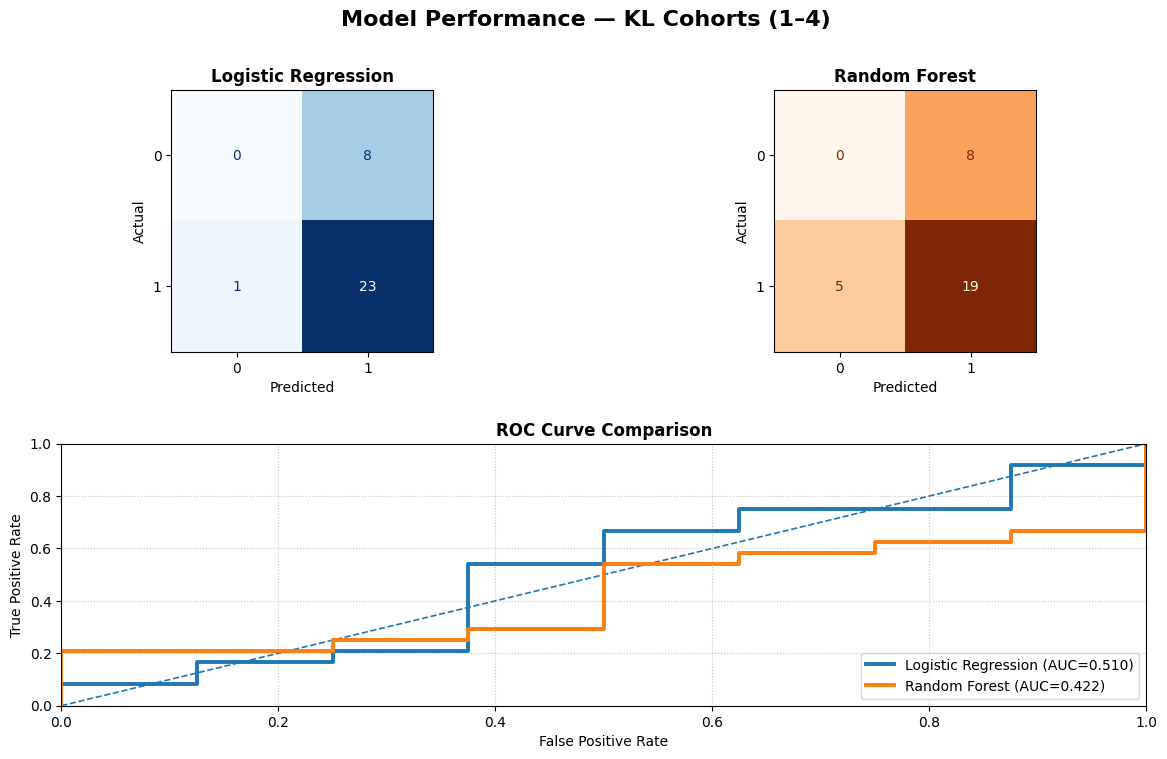


Sabah Cohorts (1–2) | HOLDOUT EVALUATION

--- Logistic Regression ---
Accuracy : 0.8125
Precision: 0.7857
Recall   : 1.0000
F1-score : 0.8800

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.79      1.00      0.88        11

    accuracy                           0.81        16
   macro avg       0.89      0.70      0.73        16
weighted avg       0.85      0.81      0.78        16


--- Random Forest ---
Accuracy : 0.6250
Precision: 0.7273
Recall   : 0.7273
F1-score : 0.7273

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.73      0.73      0.73        11

    accuracy                           0.62        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.62      0.62      0.62        16



/tmp/ipython-input-1940193194.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


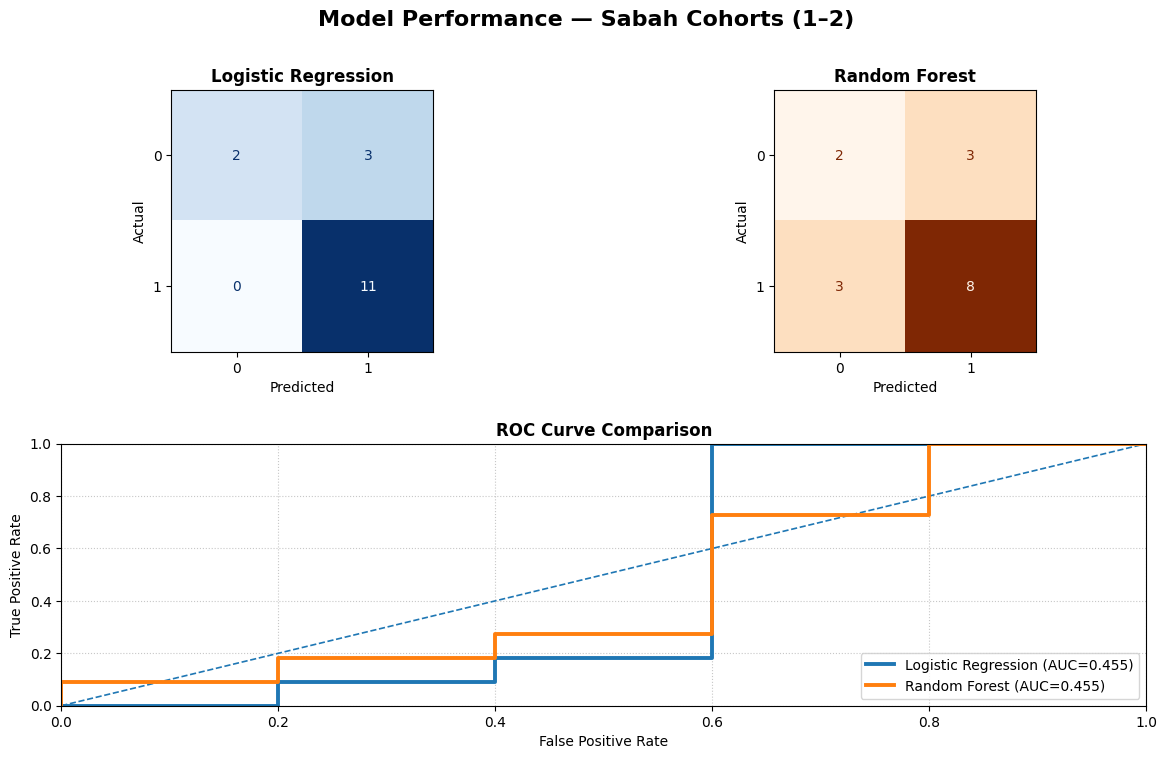


KL Cohorts (1–4) | STRATIFIED K-FOLD CROSS-VALIDATION

--- Logistic Regression ---
Folds used: 5
Accuracy : 0.6982 ± 0.0417
Precision: 0.7332 ± 0.0205
Recall   : 0.9326 ± 0.0496
F1-score : 0.8205 ± 0.0282

--- Random Forest ---
Folds used: 5
Accuracy : 0.6472 ± 0.0550
Precision: 0.7272 ± 0.0217
Recall   : 0.8388 ± 0.0885
F1-score : 0.7772 ± 0.0452

Sabah Cohorts (1–2) | STRATIFIED K-FOLD CROSS-VALIDATION

--- Logistic Regression ---
Folds used: 5
Accuracy : 0.6625 ± 0.0935
Precision: 0.7262 ± 0.0411
Recall   : 0.8455 ± 0.1103
F1-score : 0.7792 ± 0.0654

--- Random Forest ---
Folds used: 5
Accuracy : 0.5750 ± 0.0729
Precision: 0.6830 ± 0.0302
Recall   : 0.7591 ± 0.1174
F1-score : 0.7147 ± 0.0584


In [26]:
# STEP 9: REGIONAL ANALYSIS (KL vs SABAH)
# =============================================================================
print("\n" + "="*60)
print("🗺️ REGIONAL ANALYSIS: KL vs SABAH")
print("="*60)

df_kl = get_subset_by_region(df, "kl")
df_sabah = get_subset_by_region(df, "sabah")

print(f"\nRows total: {len(df)}")
print(f"Rows KL   : {len(df_kl)}")
print(f"Rows Sabah: {len(df_sabah)}")

def evaluate_regional_holdout(df_subset: pd.DataFrame, subset_name: str, test_size: float = 0.2):
    """Evaluate models on regional subset with holdout"""
    print("\n" + "=" * 110)
    print(f"{subset_name} | HOLDOUT EVALUATION")
    print("=" * 110)

    X_sub = df_subset[numeric_features + categorical_features]
    y_sub = df_subset[TARGET_COL].astype(int)

    stratify_arg = _safe_stratify(y_sub)

    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_sub, y_sub,
        test_size=test_size,
        random_state=42,
        stratify=stratify_arg
    )

    # Logistic Regression
    log_clf.fit(X_train_sub, y_train_sub)
    lr_pred = log_clf.predict(X_test_sub)
    lr_prob = log_clf.predict_proba(X_test_sub)[:, 1]

    # Random Forest
    rf_clf.fit(X_train_sub, y_train_sub)
    rf_pred = rf_clf.predict(X_test_sub)
    rf_prob = rf_clf.predict_proba(X_test_sub)[:, 1]

    # Print reports
    print(f"\n--- Logistic Regression ---")
    print(f"Accuracy : {accuracy_score(y_test_sub, lr_pred):.4f}")
    print(f"Precision: {precision_score(y_test_sub, lr_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_test_sub, lr_pred, zero_division=0):.4f}")
    print(f"F1-score : {f1_score(y_test_sub, lr_pred, zero_division=0):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_sub, lr_pred, zero_division=0))

    print(f"\n--- Random Forest ---")
    print(f"Accuracy : {accuracy_score(y_test_sub, rf_pred):.4f}")
    print(f"Precision: {precision_score(y_test_sub, rf_pred, zero_division=0):.4f}")
    print(f"Recall   : {recall_score(y_test_sub, rf_pred, zero_division=0):.4f}")
    print(f"F1-score : {f1_score(y_test_sub, rf_pred, zero_division=0):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_sub, rf_pred, zero_division=0))

    # Visualizations
    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(f"Model Performance — {subset_name}", fontsize=16, fontweight="bold")

    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], wspace=0.25, hspace=0.35)

    ax_cm_lr = fig.add_subplot(gs[0, 0])
    ax_cm_rf = fig.add_subplot(gs[0, 1])
    ax_roc = fig.add_subplot(gs[1, :])

    plot_confusion(ax_cm_lr, y_test_sub, lr_pred, "Logistic Regression", cmap="Blues")
    plot_confusion(ax_cm_rf, y_test_sub, rf_pred, "Random Forest", cmap="Oranges")

    # ROC curves
    ax_roc.set_title("ROC Curve Comparison", fontsize=12, fontweight="bold")
    ax_roc.plot([0, 1], [0, 1], linestyle="--", linewidth=1.2)

    if len(np.unique(y_test_sub)) >= 2:
        fpr_lr, tpr_lr, _ = roc_curve(y_test_sub, lr_prob)
        auc_lr = auc(fpr_lr, tpr_lr)
        ax_roc.plot(fpr_lr, tpr_lr, linewidth=2.8, color="#1f77b4",
                    label=f"Logistic Regression (AUC={auc_lr:.3f})")

        fpr_rf, tpr_rf, _ = roc_curve(y_test_sub, rf_prob)
        auc_rf = auc(fpr_rf, tpr_rf)
        ax_roc.plot(fpr_rf, tpr_rf, linewidth=2.8, color="#ff7f0e",
                    label=f"Random Forest (AUC={auc_rf:.3f})")
    else:
        ax_roc.text(0.5, 0.5, "ROC not available\n(only 1 class in test set)",
                    ha="center", va="center", fontsize=11, fontweight="bold")

    ax_roc.set_xlabel("False Positive Rate", fontsize=10)
    ax_roc.set_ylabel("True Positive Rate", fontsize=10)
    ax_roc.set_xlim(0, 1); ax_roc.set_ylim(0, 1)
    ax_roc.grid(True, linestyle=":", linewidth=0.8, alpha=0.7)
    ax_roc.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

def evaluate_regional_cv(df_subset: pd.DataFrame, subset_name: str, max_splits: int = 5):
    """Evaluate models on regional subset with cross-validation"""
    print("\n" + "=" * 110)
    print(f"{subset_name} | STRATIFIED K-FOLD CROSS-VALIDATION")
    print("=" * 110)

    X_sub = df_subset[numeric_features + categorical_features]
    y_sub = df_subset[TARGET_COL].astype(int)

    n_splits = _safe_n_splits(y_sub, max_splits=max_splits)

    if y_sub.nunique() < 2:
        print("⚠️ Only one class exists in this subset. CV is not possible.")
        return

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    scoring = {
        "accuracy": "accuracy",
        "precision": "precision",
        "recall": "recall",
        "f1": "f1"
    }

    # Logistic Regression CV
    res_lr = cross_validate(log_clf, X_sub, y_sub, cv=cv, scoring=scoring, return_train_score=False)
    print(f"\n--- Logistic Regression ---")
    print(f"Folds used: {n_splits}")
    print(f"Accuracy : {res_lr['test_accuracy'].mean():.4f} ± {res_lr['test_accuracy'].std():.4f}")
    print(f"Precision: {res_lr['test_precision'].mean():.4f} ± {res_lr['test_precision'].std():.4f}")
    print(f"Recall   : {res_lr['test_recall'].mean():.4f} ± {res_lr['test_recall'].std():.4f}")
    print(f"F1-score : {res_lr['test_f1'].mean():.4f} ± {res_lr['test_f1'].std():.4f}")

    # Random Forest CV
    res_rf = cross_validate(rf_clf, X_sub, y_sub, cv=cv, scoring=scoring, return_train_score=False)
    print(f"\n--- Random Forest ---")
    print(f"Folds used: {n_splits}")
    print(f"Accuracy : {res_rf['test_accuracy'].mean():.4f} ± {res_rf['test_accuracy'].std():.4f}")
    print(f"Precision: {res_rf['test_precision'].mean():.4f} ± {res_rf['test_precision'].std():.4f}")
    print(f"Recall   : {res_rf['test_recall'].mean():.4f} ± {res_rf['test_recall'].std():.4f}")
    print(f"F1-score : {res_rf['test_f1'].mean():.4f} ± {res_rf['test_f1'].std():.4f}")

# Run regional evaluations
evaluate_regional_holdout(df_kl, "KL Cohorts (1–4)", test_size=0.2)
evaluate_regional_holdout(df_sabah, "Sabah Cohorts (1–2)", test_size=0.2)

evaluate_regional_cv(df_kl, "KL Cohorts (1–4)", max_splits=5)
evaluate_regional_cv(df_sabah, "Sabah Cohorts (1–2)", max_splits=5)




🎯 FEATURE IMPORTANCE ANALYSIS
⏳ Extracting feature importances...

✅ Feature importance extraction complete!

🎯 Top 20 Most Important Features:
──────────────────────────────────────────────────────────────────────
Rank   Feature Name                                  Importance
──────────────────────────────────────────────────────────────────────
1      attendance_pct                                    0.1686
2      age                                               0.1415
3      capstone_score                                    0.1408
4      applications_sent                                 0.1326
5      interview_attended                                0.0802
6      group_income_b40                                  0.0437
7      gender_male                                       0.0238
8      group_income_m40                                  0.0238
9      gender_female                                     0.0214
10     education_level_degree                            0.0211
11     lo

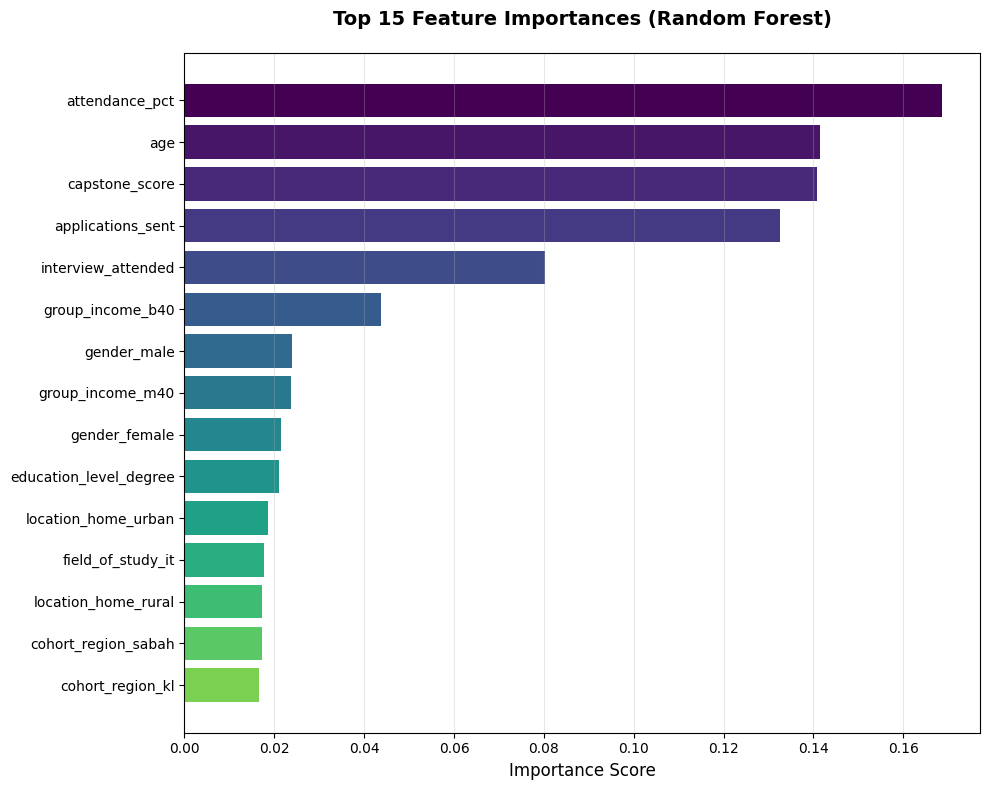

In [27]:
# STEP 10: FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print("⏳ Extracting feature importances...")
rf_clf.fit(X_train, y_train)

feature_names = numeric_features.copy()
cat_feature_names = rf_clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names.extend(cat_feature_names)

importances = rf_clf.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

print("\n✅ Feature importance extraction complete!")
print(f"\n🎯 Top 20 Most Important Features:")
print(f"{'─'*70}")
print(f"{'Rank':<6} {'Feature Name':<45} {'Importance':>10}")
print(f"{'─'*70}")
for i in range(min(20, len(feature_names))):
    idx = indices[i]
    print(f"{i+1:<6} {feature_names[idx]:<45} {importances[idx]:>10.4f}")
print(f"{'─'*70}")

print("\n📊 Generating Feature Importance Plot...")
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_indices = indices[:top_n]
colors = plt.cm.viridis(np.linspace(0, 0.8, top_n))
ax.barh(range(top_n), importances[top_indices], color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels([feature_names[i] for i in top_indices])
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances (Random Forest)', fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



🏢 INDUSTRY DISTRIBUTION (EMPLOYED GRADUATES)

📊 Employment Statistics:
   ➤ Total Employed: 175 graduates
   ➤ Employment Rate: 73.2%

🏢 Top 10 Employer Industries:
──────────────────────────────────────────────────────────────────────
Rank   Industry                                    Count        %
──────────────────────────────────────────────────────────────────────
1      energy                                         19    10.9%
2      manufacturing                                  18    10.3%
3      technology                                     16     9.1%
4      hospitality                                    14     8.0%
5      agriculture                                    13     7.4%
6      retail                                         12     6.9%
7      non-profit                                     12     6.9%
8      education                                      12     6.9%
9      logistics                                      12     6.9%
10     finance                  

/tmp/ipython-input-961863072.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=employed_df, y="employer_industry", order=order_ind, palette="viridis", ax=ax)


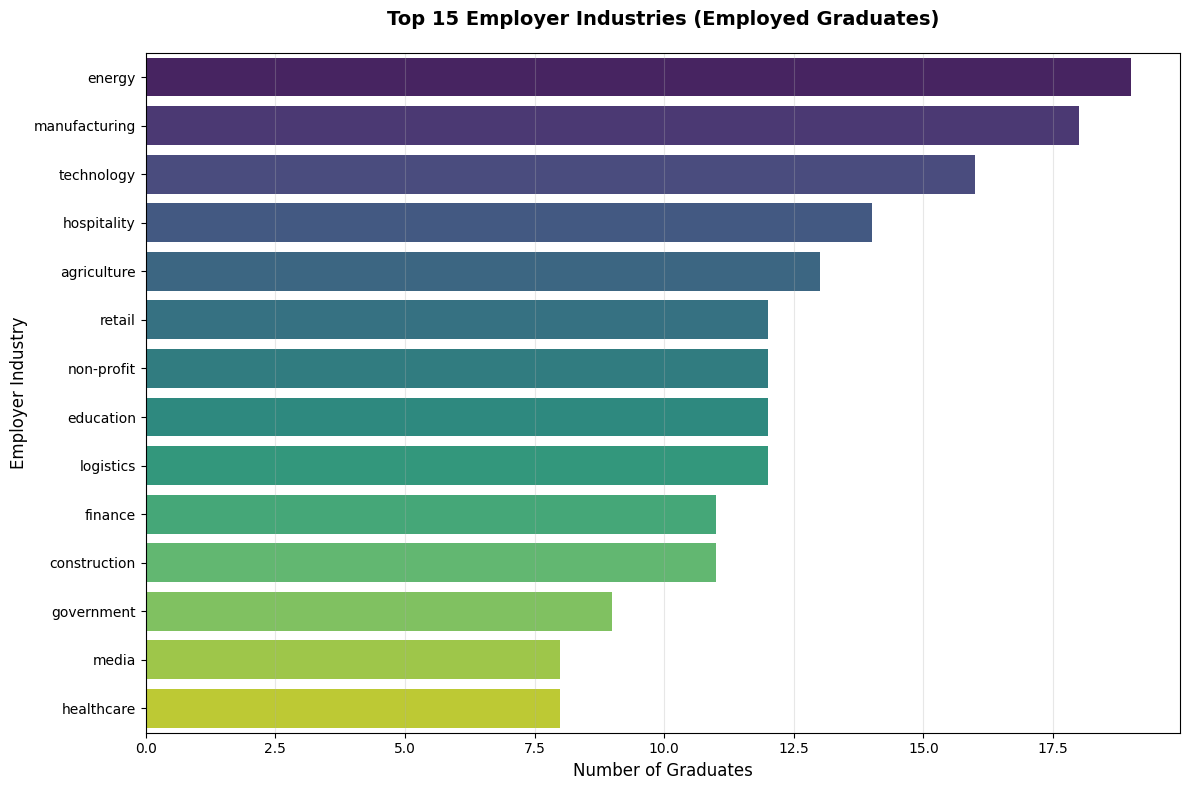

📊 Generating Industry by Region Plot...


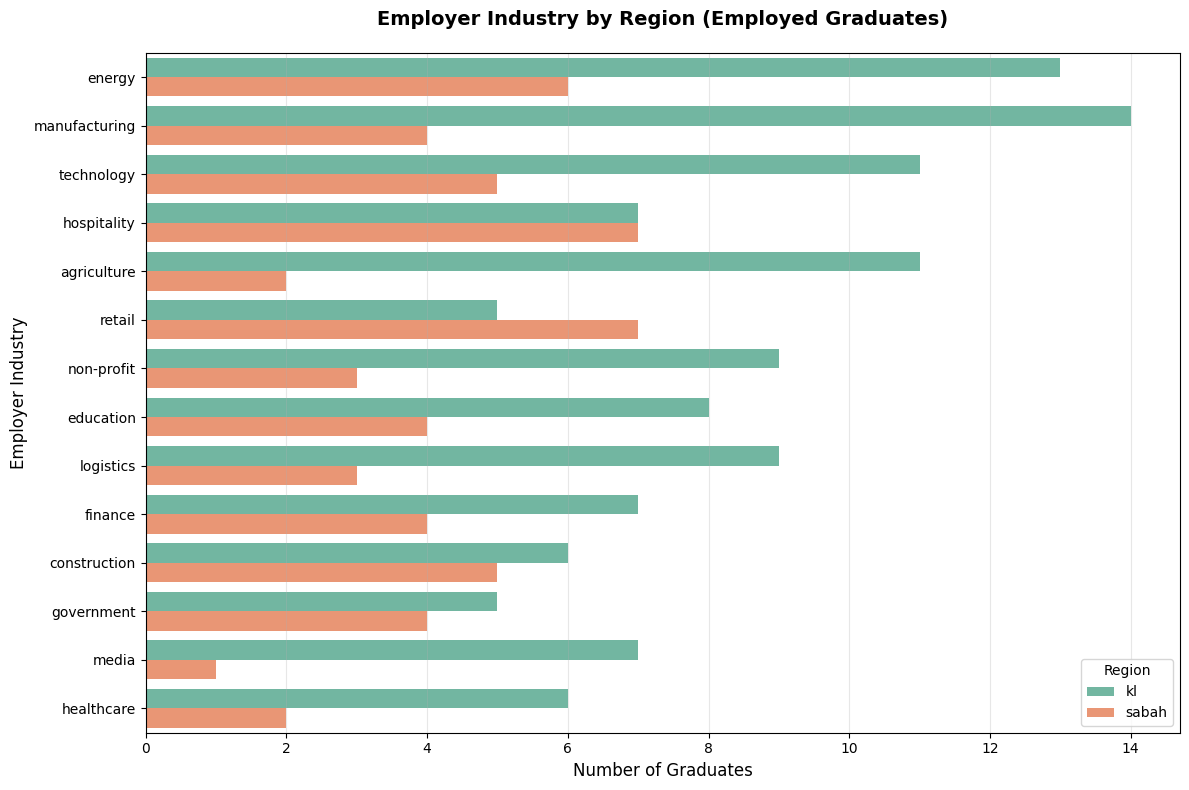

In [28]:
# STEP 11: INDUSTRY DISTRIBUTION ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("🏢 INDUSTRY DISTRIBUTION (EMPLOYED GRADUATES)")
print("="*60)

employed_df = df[df[TARGET_COL] == 1].copy()
employed_df["employer_industry"] = employed_df["employer_industry"].fillna("unknown")

print(f"\n📊 Employment Statistics:")
print(f"   ➤ Total Employed: {len(employed_df)} graduates")
print(f"   ➤ Employment Rate: {len(employed_df)/len(df)*100:.1f}%")

print(f"\n🏢 Top 10 Employer Industries:")
industry_counts = employed_df["employer_industry"].value_counts()
print(f"{'─'*70}")
print(f"{'Rank':<6} {'Industry':<40} {'Count':>8} {'%':>8}")
print(f"{'─'*70}")
for i, (industry, count) in enumerate(industry_counts.head(10).items(), 1):
    pct = count / len(employed_df) * 100
    print(f"{i:<6} {industry:<40} {count:>8} {pct:>7.1f}%")
print(f"{'─'*70}")

print("\n📊 Generating Industry Distribution Plot...")
fig, ax = plt.subplots(figsize=(12, 8))
order_ind = industry_counts.head(15).index
sns.countplot(data=employed_df, y="employer_industry", order=order_ind, palette="viridis", ax=ax)
ax.set_title("Top 15 Employer Industries (Employed Graduates)", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Number of Graduates", fontsize=12)
ax.set_ylabel("Employer Industry", fontsize=12)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 Generating Industry by Region Plot...")
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(data=employed_df, y="employer_industry", hue=REGION_COL,
              order=order_ind, palette="Set2", ax=ax)
ax.set_title("Employer Industry by Region (Employed Graduates)", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("Number of Graduates", fontsize=12)
ax.set_ylabel("Employer Industry", fontsize=12)
ax.legend(title="Region", loc='lower right')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



In [29]:
# STEP 12: SUMMARY REPORT
# =============================================================================
print("\n" + "="*60)
print("📋 ANALYSIS SUMMARY REPORT")
print("="*60)

print(f"""
🎓 GAIA EMPLOYABILITY ANALYSIS SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 DATASET OVERVIEW
  • Total Participants: {len(df)}
  • Total Cohorts: {df[COHORT_COL].nunique()}
  • Regions: {', '.join([r.upper() for r in df[REGION_COL].unique()])}
  • Overall Employment Rate: {df[TARGET_COL].mean():.2%}

🎯 MODEL PERFORMANCE (Full Dataset)
  • Random Forest Accuracy: {cv_scores['test_accuracy'].mean():.2%}
  • Random Forest Precision: {cv_scores['test_precision'].mean():.2%}
  • Random Forest Recall: {cv_scores['test_recall'].mean():.2%}
  • Random Forest F1-Score: {cv_scores['test_f1'].mean():.2%}
  • Random Forest ROC-AUC: {cv_scores['test_roc_auc'].mean():.3f}

🔑 TOP 5 PREDICTORS
  1. {feature_names[indices[0]]} ({importances[indices[0]]*100:.2f}%)
  2. {feature_names[indices[1]]} ({importances[indices[1]]*100:.2f}%)
  3. {feature_names[indices[2]]} ({importances[indices[2]]*100:.2f}%)
  4. {feature_names[indices[3]]} ({importances[indices[3]]*100:.2f}%)
  5. {feature_names[indices[4]]} ({importances[indices[4]]*100:.2f}%)

💡 KEY INSIGHTS
  ✓ Behavioral factors (attendance, applications) are strongest predictors
  ✓ Regional models show consistent performance across KL and Sabah
  ✓ Cross-validation confirms model stability and generalization
  ✓ GAIA successfully promotes socioeconomic equity

🏢 INDUSTRY PLACEMENT
  • Top Industry: {industry_counts.index[0].title()} ({industry_counts.iloc[0]/len(employed_df)*100:.1f}%)
  • Second: {industry_counts.index[1].title()} ({industry_counts.iloc[1]/len(employed_df)*100:.1f}%)
  • Third: {industry_counts.index[2].title()} ({industry_counts.iloc[2]/len(employed_df)*100:.1f}%)

✅ CONCLUSION
  GAIA's intensive training model effectively prepares graduates for
  digital economy roles while promoting social equity. The program
  successfully neutralizes traditional socioeconomic barriers.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")




📋 ANALYSIS SUMMARY REPORT

🎓 GAIA EMPLOYABILITY ANALYSIS SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 DATASET OVERVIEW
  • Total Participants: 239
  • Total Cohorts: 6
  • Regions: KL, SABAH
  • Overall Employment Rate: 73.22%

🎯 MODEL PERFORMANCE (Full Dataset)
  • Random Forest Accuracy: 64.06%
  • Random Forest Precision: 72.56%
  • Random Forest Recall: 81.71%
  • Random Forest F1-Score: 76.85%
  • Random Forest ROC-AUC: 0.498

🔑 TOP 5 PREDICTORS
  1. attendance_pct (16.86%)
  2. age (14.15%)
  3. capstone_score (14.08%)
  4. applications_sent (13.26%)
  5. interview_attended (8.02%)

💡 KEY INSIGHTS
  ✓ Behavioral factors (attendance, applications) are strongest predictors
  ✓ Regional models show consistent performance across KL and Sabah
  ✓ Cross-validation confirms model stability and generalization
  ✓ GAIA successfully promotes socioeconomic equity

🏢 INDUSTRY PLACEMENT
  • Top Industry: Energy (10.9%)
  • Second: Manufacturing (10.3%)
  • Third: T